## Notebook - Table of Contents


1. [**Basic Data Analysis**](#1.-Basic-Data-Analysis)  
    1.1 [**Importing the necessary libraries & loading the data**](#1.1-Importing-the-necessary-libraries-&-loading-the-data)    
    1.2 [**Basic statistics - Number of products, subcategories & gender**](#1.2-Basic-statistics---Number-of-products,-subcategories-&-gender)      
    1.3 [**Frequency of each gender**](#1.3-Frequency-of-each-gender)      
    1.4 [**Distribution of products gender-wise**](#1.4-Distribution-of-products-gender-wise)     
2. [**Data Preparation**](#2.-Data-Preparation) 
3. [**Feature extraction using ResNet**](#3.-Feature-extraction-using-ResNet)  
4. [**Computing the Euclidean distance and recommending similar products**](#4.-Computing-the-Euclidean-distance-and-recommending-similar-products)                         
    4.1 [**Loading the extracted features**](#4.1-Loading-the-extracted-features)  
    4.2 [**Distance computation and Recommendation**](#4.2-Distance-computation-and-Recommendation)  
5. [**Deploying the solution**](#5.-Deploying-the-solution)  

### Basic Data Analysis

#### 1.1 Importing the necessary libraries & loading the data

In [1]:
# Importing necessary libraries for data manipulation and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Importing libraries for deep learning using Keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications

# Importing library for calculating pairwise distances
from sklearn.metrics import pairwise_distances

# Importing library for making HTTP requests
import requests

# Importing the Python Imaging Library for image processing
from PIL import Image

# Importing the pickle library for serialization and deserialization of Python objects
import pickle

# Importing the datetime library for working with dates and times
from datetime import datetime

# Adjusting the behavior of the PIL library to handle truncated images
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Importing libraries for creating interactive visualizations with Plotly
import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.express as px

# Importing the Streamlit library for creating web applications
#import streamlit as st

# Importing a library for displaying images in Jupyter notebooks
from IPython.display import display, Image

# Reading a CSV file containing fashion data into a Pandas DataFrame
fashion_df = pd.read_csv("/kaggle/input/fashion-images/data/fashion.csv")

# Displaying the DataFrame
fashion_df


,ProductId,Gender,Category,SubCategory,ProductType,Colour,Usage,ProductTitle,Image,ImageURL
0,42419,Girls,Apparel,Topwear,Tops,White,Casual,Gini and Jony Girls Knit White Top,42419.jpg,http://assets.myntassets.com/v1/images/style/p...
1,34009,Girls,Apparel,Topwear,Tops,Black,Casual,Gini and Jony Girls Black Top,34009.jpg,http://assets.myntassets.com/v1/images/style/p...
2,40143,Girls,Apparel,Topwear,Tops,Blue,Casual,Gini and Jony Girls Pretty Blossom Blue Top,40143.jpg,http://assets.myntassets.com/v1/images/style/p...
3,23623,Girls,Apparel,Topwear,Tops,Pink,Casual,Doodle Kids Girls Pink I love Shopping Top,23623.jpg,http://assets.myntassets.com/v1/images/style/p...
4,47154,Girls,Apparel,Bottomwear,Capris,Black,Casual,Gini and Jony Girls Black Capris,47154.jpg,http://assets.myntassets.com/v1/images/style/p...
...,...,...,...,...,...,...,...,...,...,...
2901,51755,Women,Footwear,Shoes,Casual Shoes,Black,Casual,Catwalk Women Black Shoes,51755.jpg,http://assets.myntassets.com/v1/images/style/p...
2902,47630,Women,Footwear,Shoes,Flats,Blue,Casual,Carlton London Women Blue Shoes,47630.jpg,http://assets.myntassets.com/v1/images/style/p...
2903,32836,Women,Footwear,Shoes,Flats,Pink,Casual,Grendha Women Flori Pink Sandals,32836.jpg,http://assets.myntassets.com/v1/images/style/p...
2904,35821,Women,Footwear,Shoes,Heels,Black,Casual,Enroute Women Black Heels,35821.jpg,http://assets.myntassets.com/v1/images/style/p...


#### 1.2 Basic statistics - Number of products, subcategories & gender

In [2]:
print("Total number of products : ", fashion_df.shape[0])
print("Total number of unique subcategories : ", fashion_df["SubCategory"].nunique())
print("Total number of unique gender types : ", fashion_df["Gender"].nunique())

Total number of products :  2906
Total number of unique subcategories :  9
Total number of unique gender types :  4


#### 1.3 Frequency of each gender

In [3]:
fashion_df["Gender"].value_counts()

Men      811
Women    769
Boys     759
Girls    567
Name: Gender, dtype: int64

#### 1.4 Distribution of products gender-wise

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


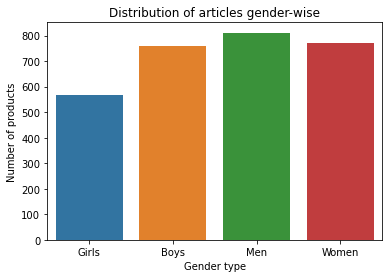

In [4]:
plot = sns.countplot(fashion_df["Gender"])
plt.title("Distribution of articles gender-wise")
plt.xlabel("Gender type")
plt.ylabel("Number of products")
plot.set_xticklabels(plot.get_xticklabels())
plt.show()

### 2. Data Preparation

In [5]:
apparel_boys = fashion_df[fashion_df["Gender"]=="Boys"]
apparel_girls = fashion_df[fashion_df["Gender"]=="Girls"]
footwear_men = fashion_df[fashion_df["Gender"]=="Men"]
footwear_women = fashion_df[fashion_df["Gender"]=="Women"]

### 3. Feature extraction using ResNet

**For Gender - Men**

In [6]:
# Setting the dimensions for input images
img_width, img_height = 224, 224

# Directory path for training data
train_data_dir = "/kaggle/input/fashion-images/data/Footwear/Men/Images/"

# Number of training samples
nb_train_samples = 811

# Number of training epochs
epochs = 50

# Batch size for training
batch_size = 1

# Function to extract features using a pre-trained ResNet50 model
def extract_features():
    # List to store item codes extracted from file names
    Itemcodes = []
    
    # ImageDataGenerator for preprocessing images
    datagen = ImageDataGenerator(rescale=1. / 255)
    
    # Loading the ResNet50 model without the top layers
    model = applications.ResNet50(include_top=False, weights='imagenet')
    
    # Generating a flow of images from the specified directory
    generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    
    # Extracting item codes from file names
    for i in generator.filenames:
        Itemcodes.append(i[(i.find("/")+1):i.find(".")])
    
    # Predicting features using the ResNet50 model
    extracted_features = model.predict_generator(generator, nb_train_samples // batch_size)
    
    # Reshaping the extracted features
    extracted_features = extracted_features.reshape((811, 100352))
    
    # Saving the extracted features and corresponding item codes as numpy arrays
    np.save(open('./Men_ResNet_features.npy', 'wb'), extracted_features)
    np.save(open('./Men_ResNet_feature_product_ids.npy', 'wb'), np.array(Itemcodes))
     
# Recording the start time
a = datetime.now()

# Calling the feature extraction function
extract_features()

# Printing the time taken for feature extraction
print("Time taken in feature extraction", datetime.now()-a)


94773248/94765736 [==============================] - 4s 0us/step
Found 811 images belonging to 1 classes.


/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Time taken in feature extraction 0:01:49.341854


### 4. Computing the Euclidean distance and recommending similar products

#### 4.1 Loading the extracted features

In [7]:
# Loading previously saved extracted features and corresponding product IDs from numpy files
extracted_features = np.load('/kaggle/working/Men_ResNet_features.npy')
Productids = np.load('/kaggle/working/Men_ResNet_feature_product_ids.npy')

# Creating a copy of the original 'footwear_men' DataFrame
men = footwear_men.copy()

# Alternatively, reading a CSV file into the 'men' DataFrame
# men = pd.read_csv('./footwear_men.csv')

# Extracting the 'ProductId' column values from the 'men' DataFrame and converting to a list
df_Productids = list(men['ProductId'])

# Converting the 'Productids' numpy array to a list
Productids = list(Productids)


#### 4.2 Distance computation and Recommendation

==================== input product image ====================


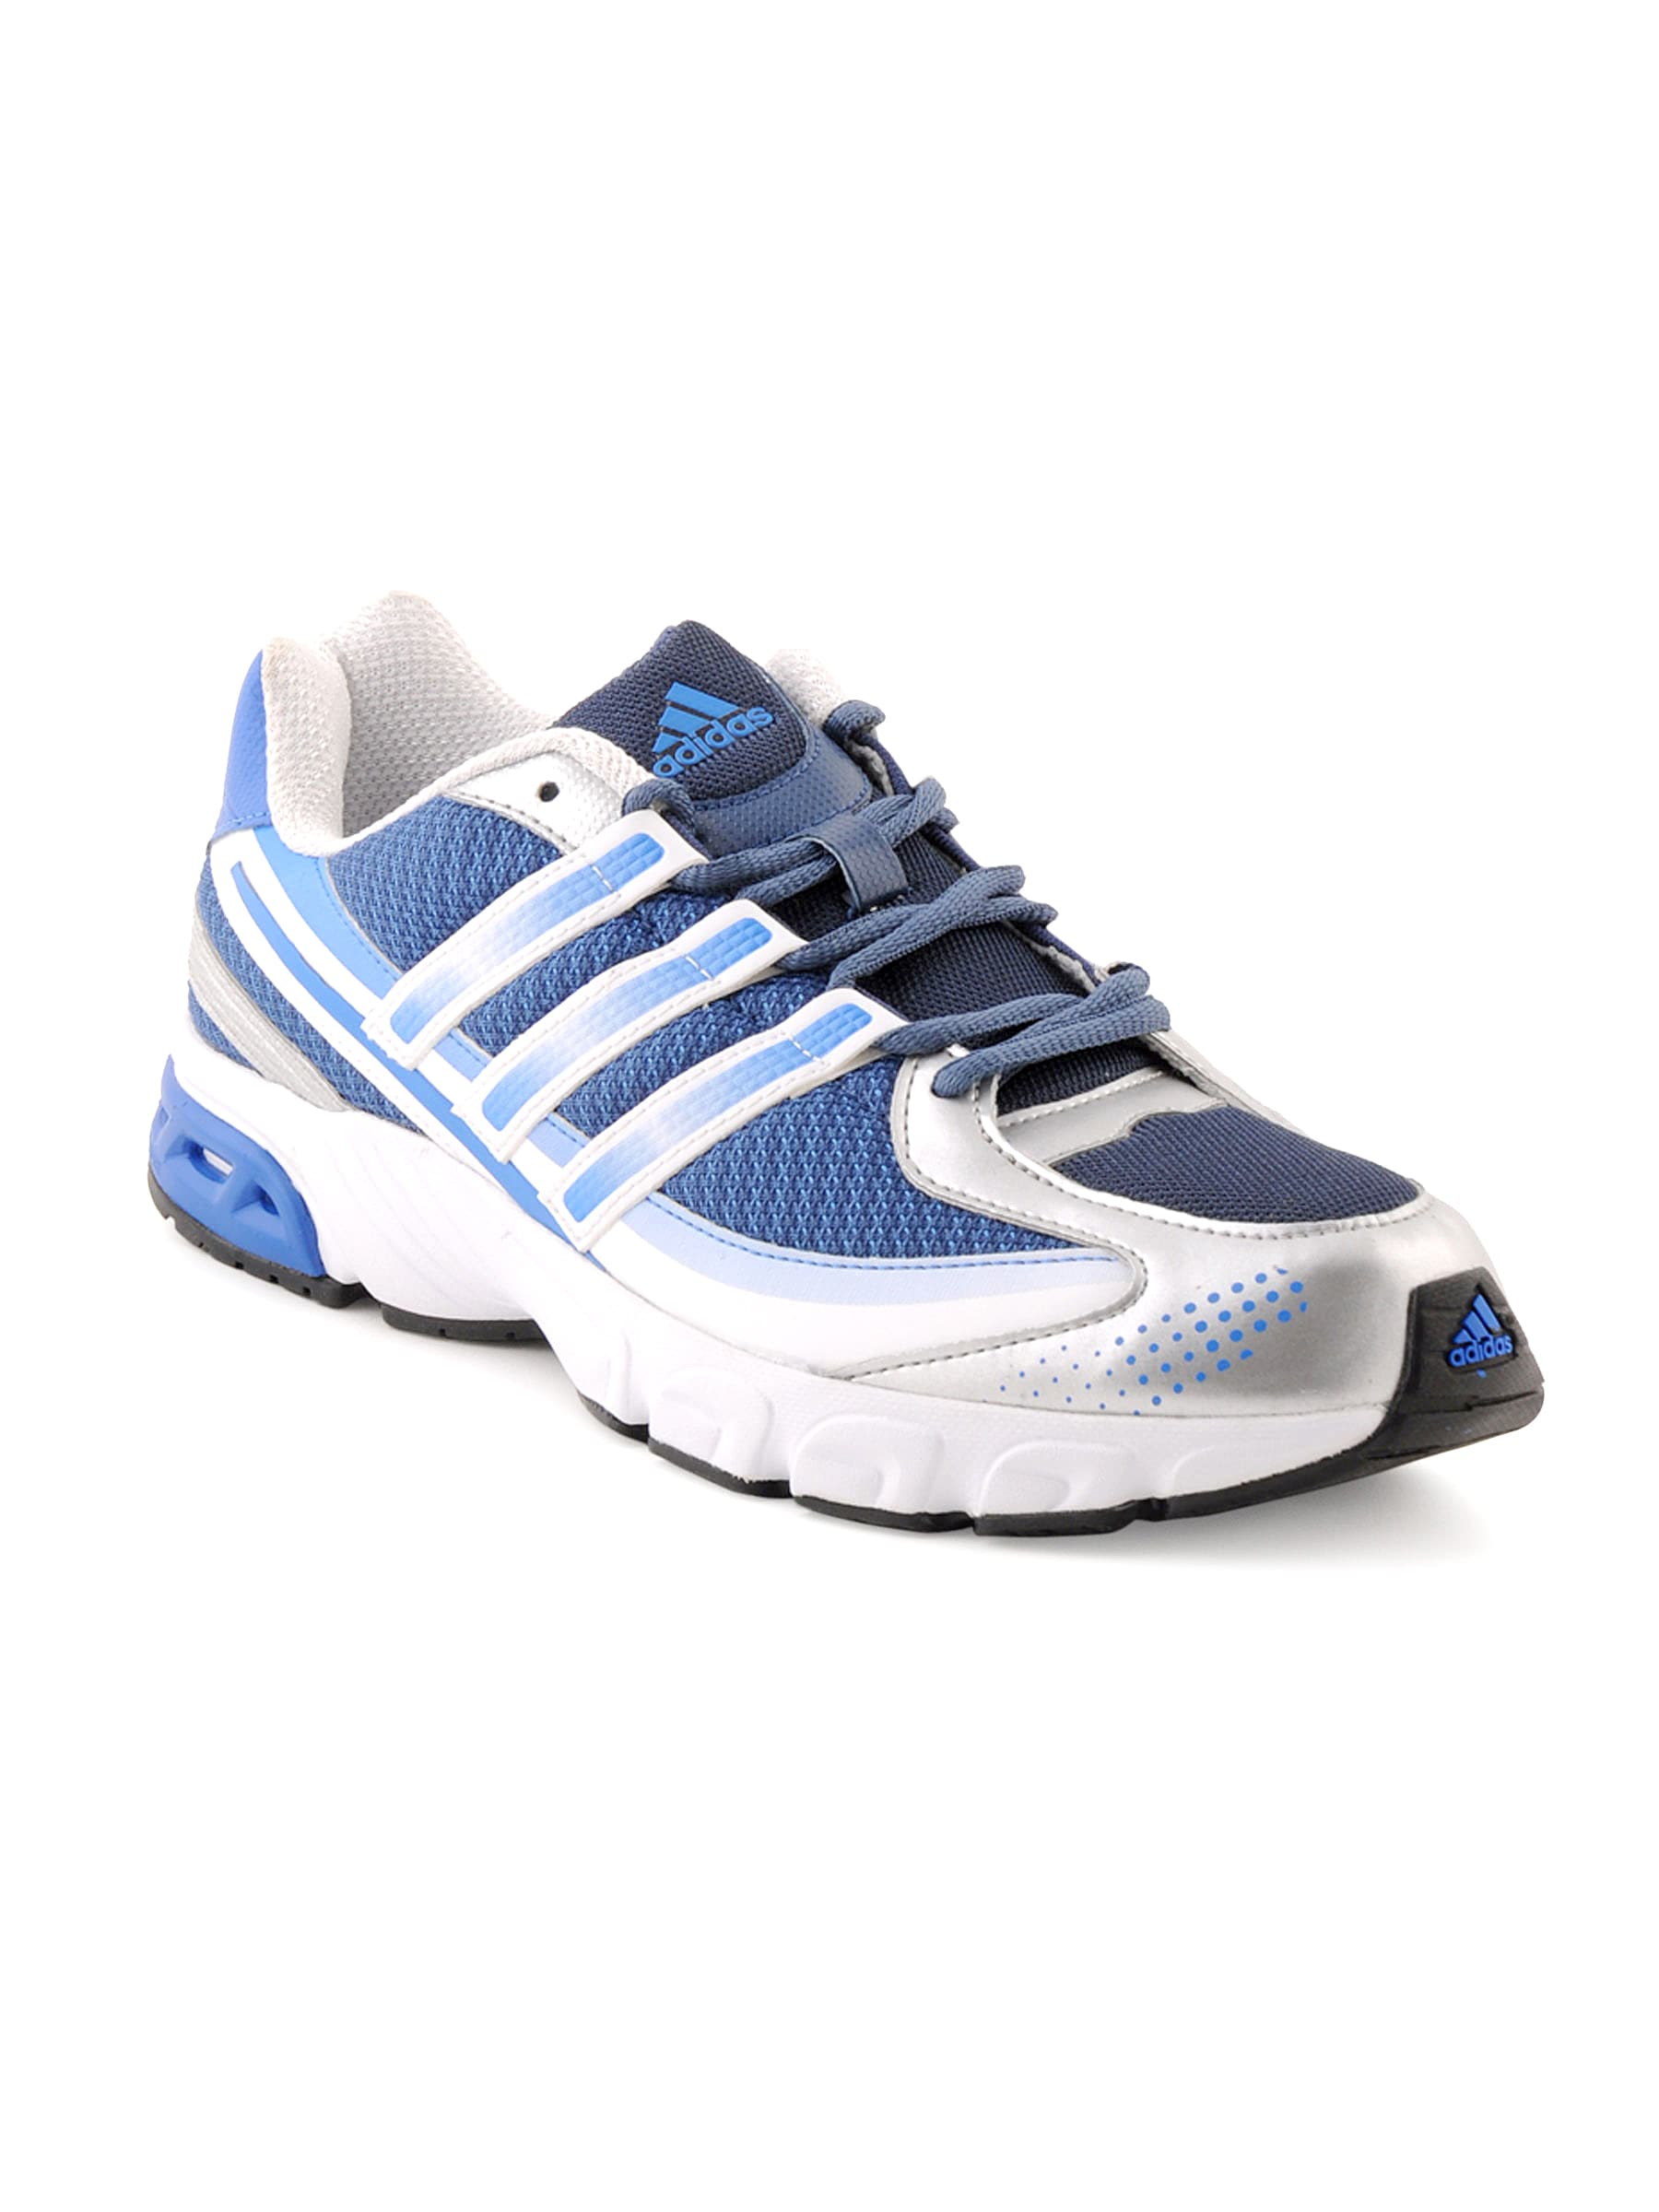

Product Title:  ADIDAS Men Adi Quest Blue Sports Shoes

 ==================== Recommended products ====================


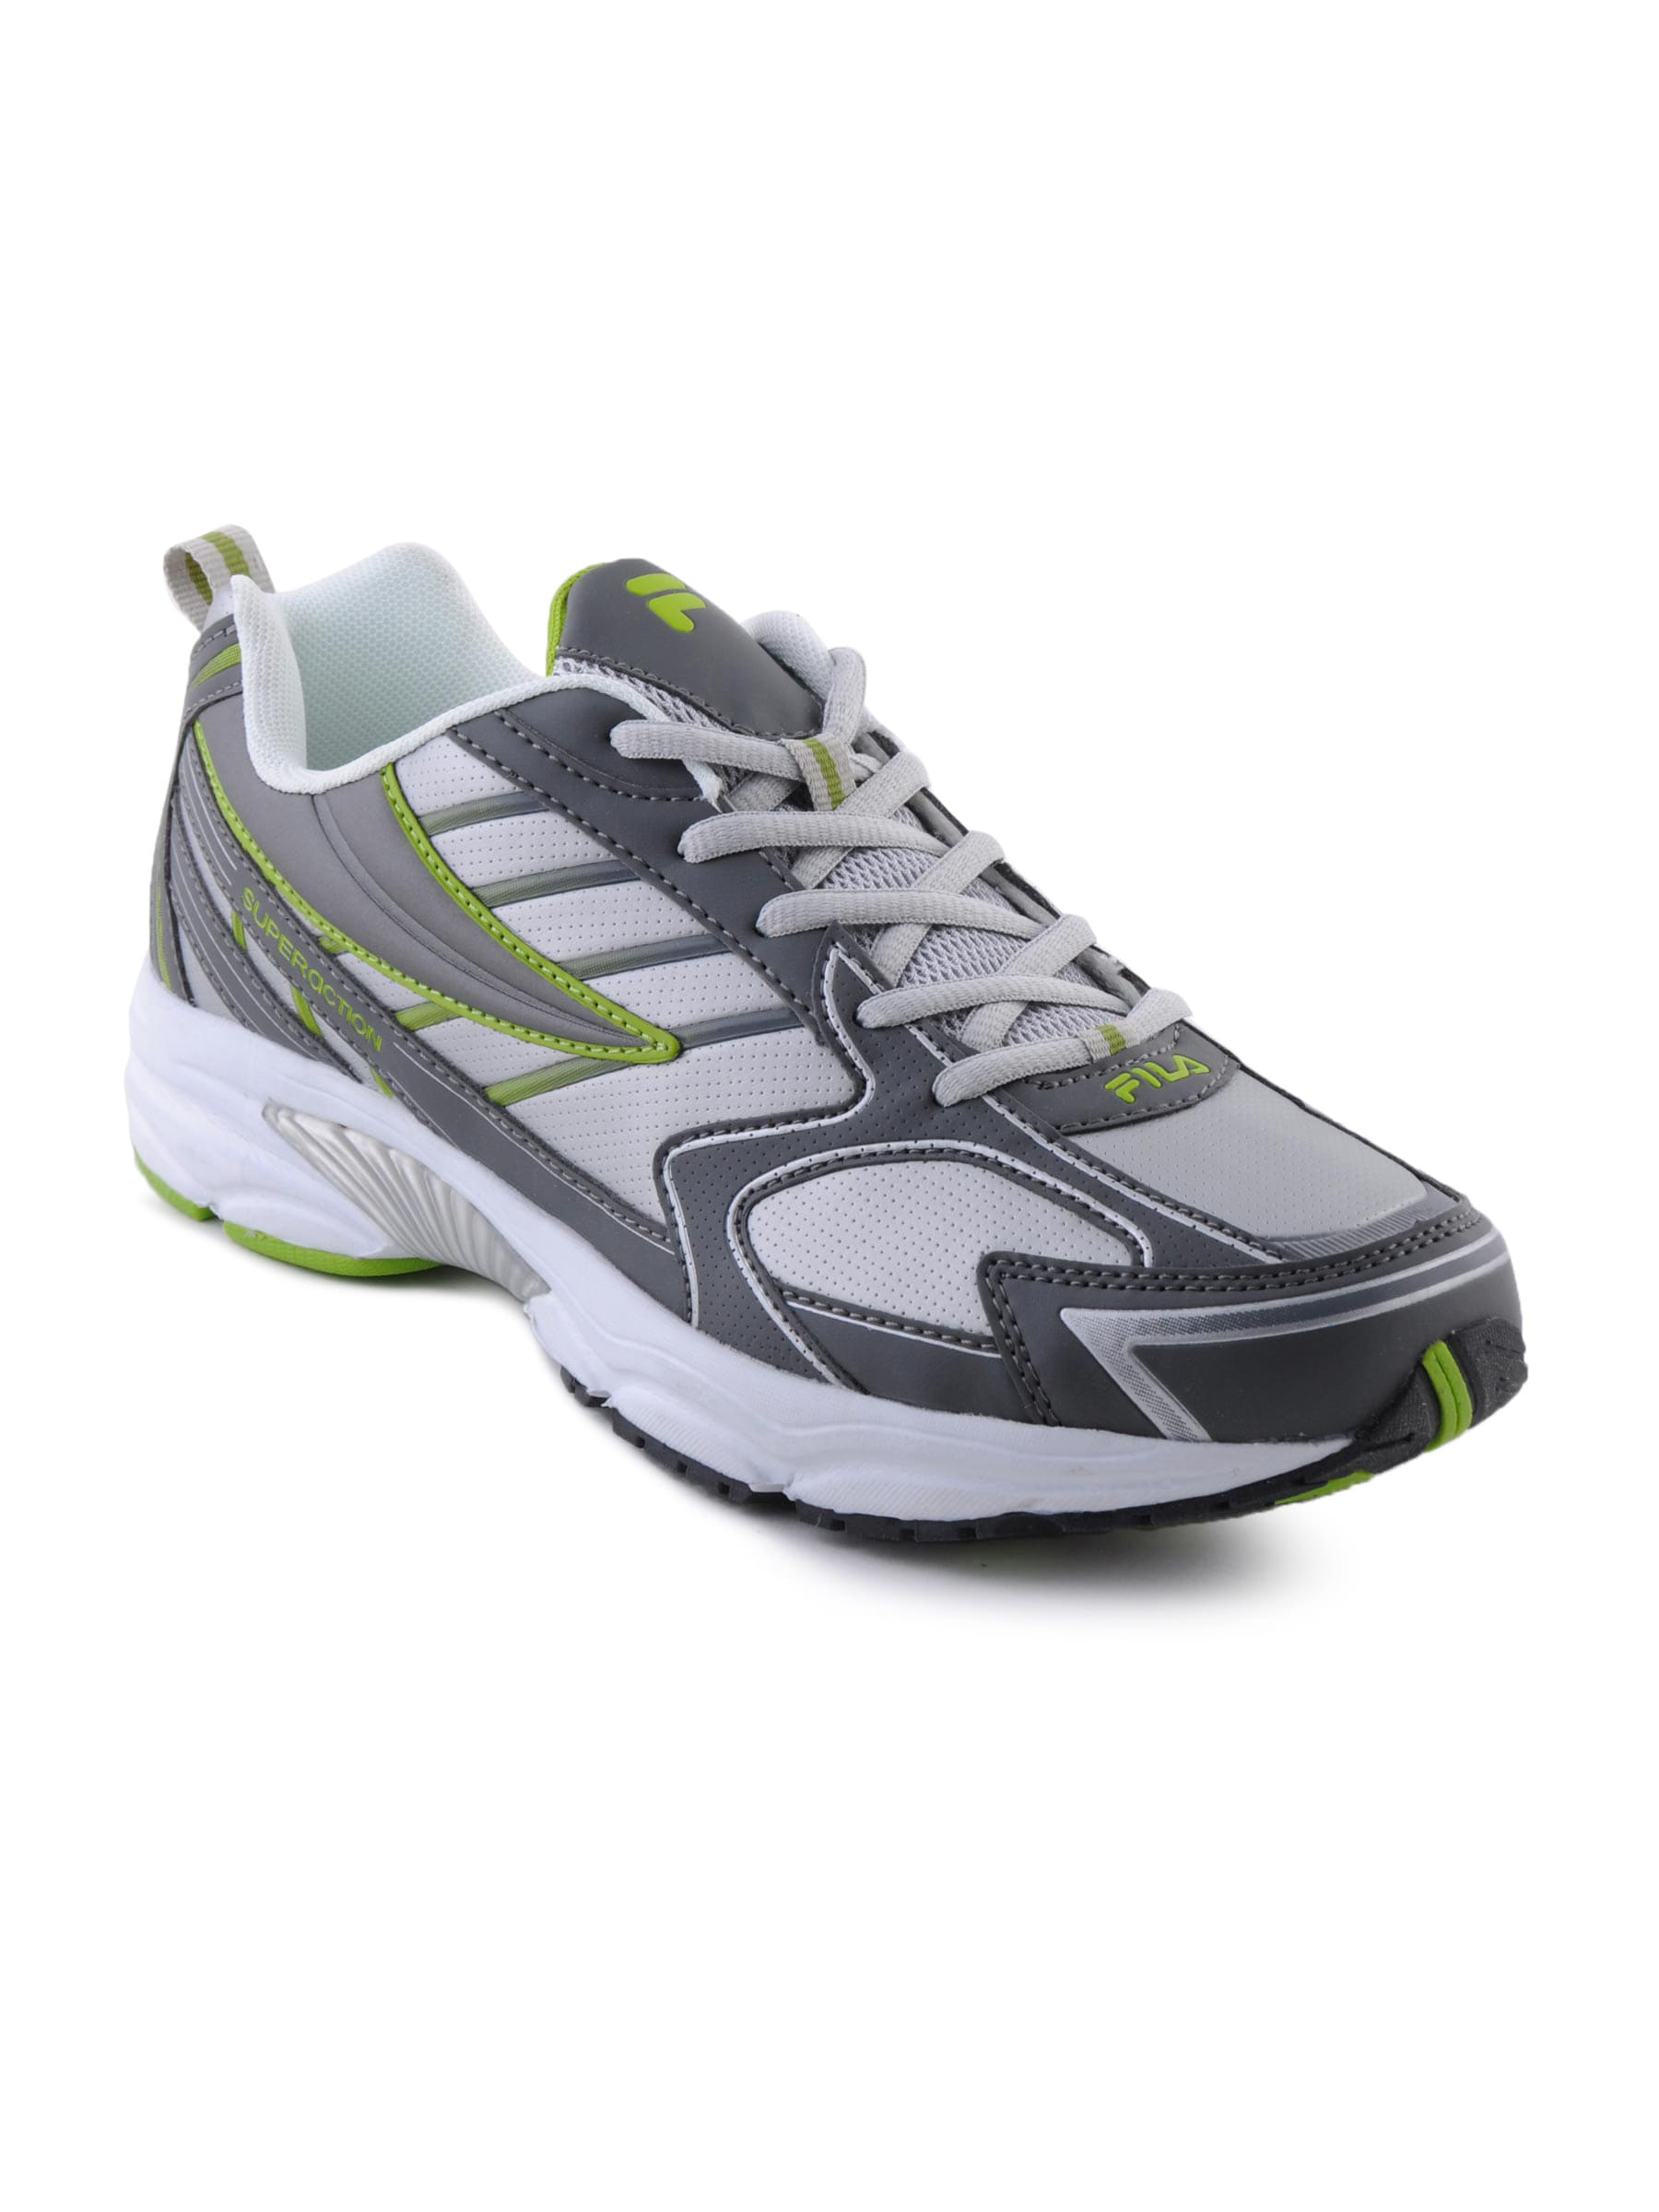

Product Title:  Fila Men Destiny Grey Sports Shoes
Euclidean Distance from input image: 27.668856


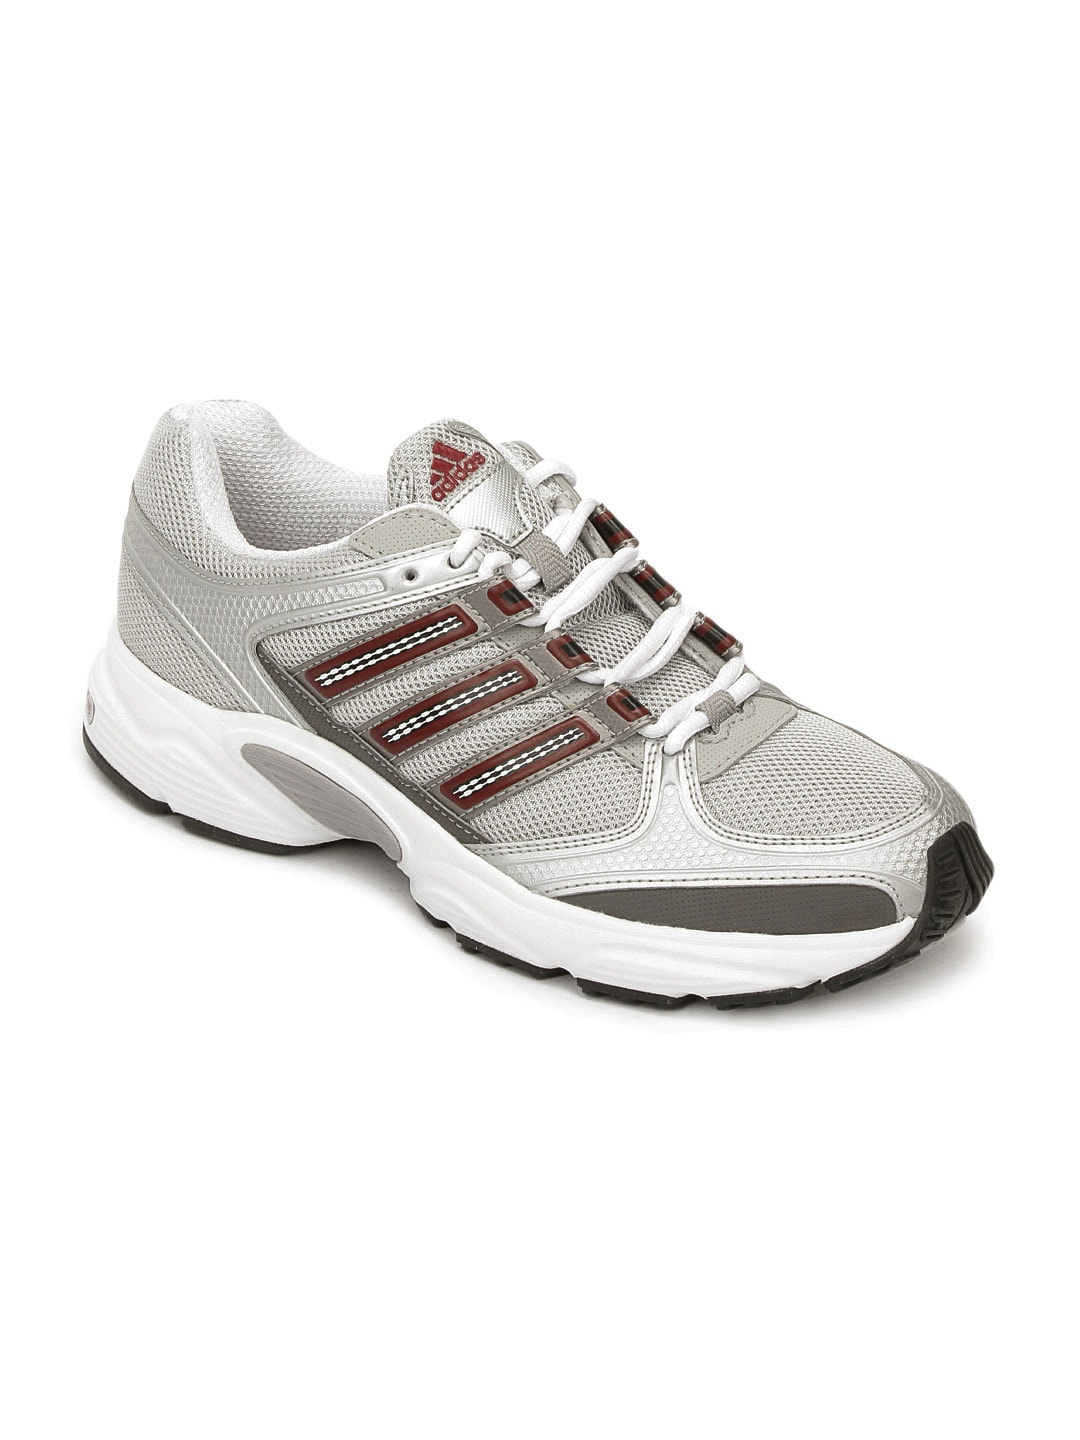

Product Title:  ADIDAS Men Silver Phaedra Shoes
Euclidean Distance from input image: 29.393417


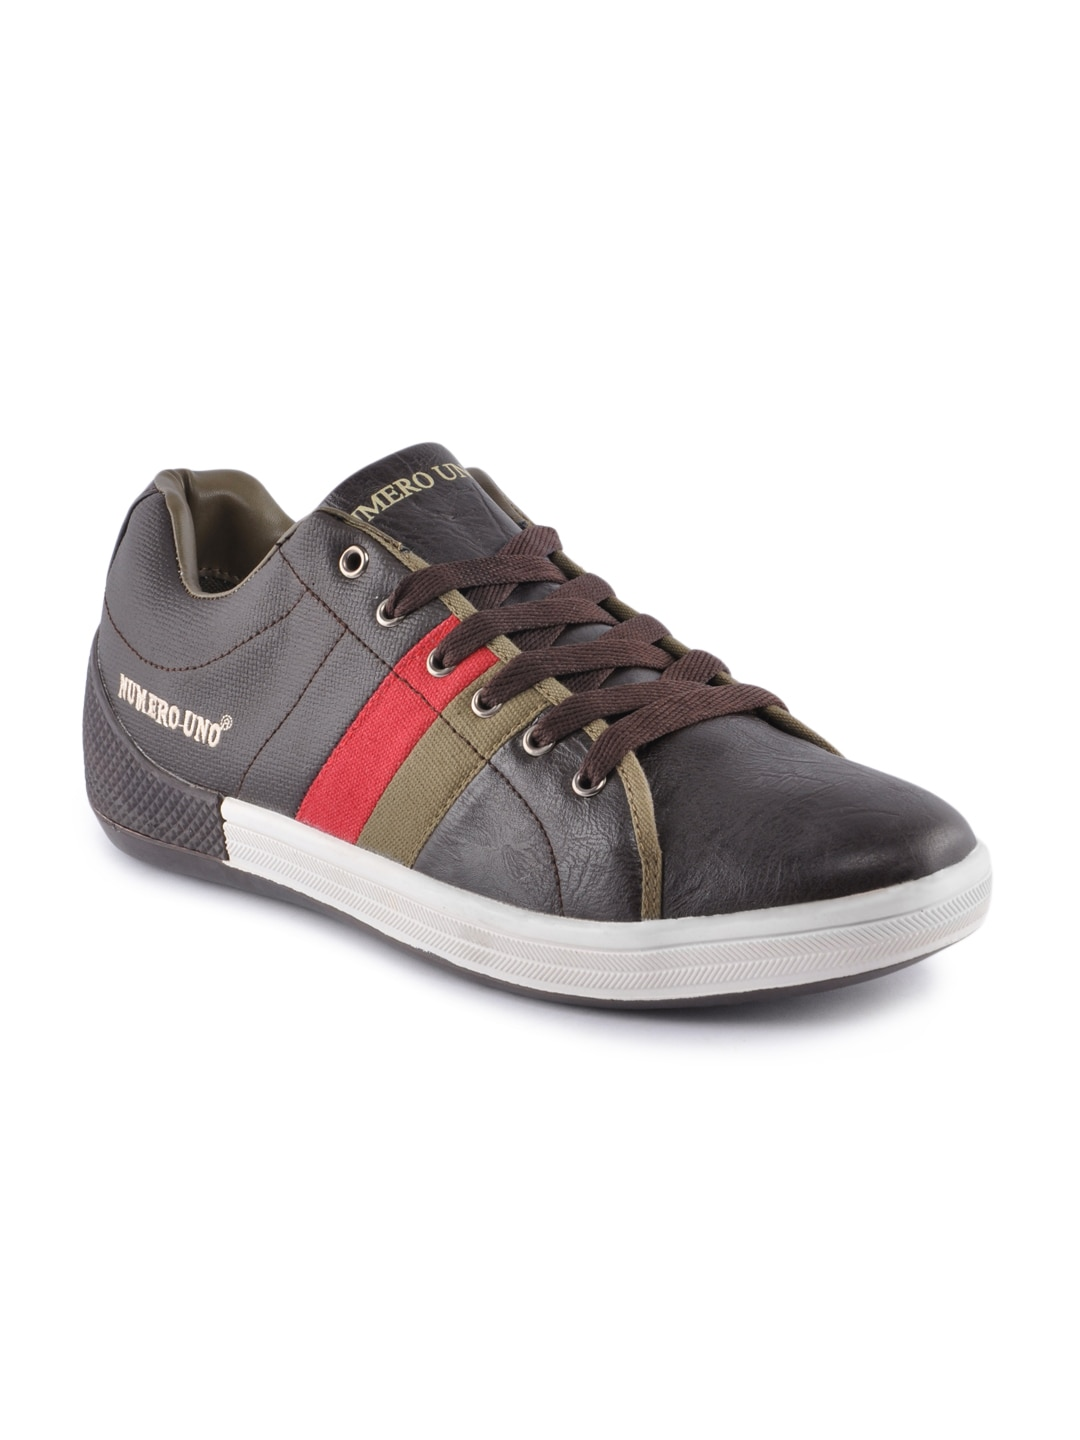

Product Title:  Numero Uno Men Brown Casual Shoes
Euclidean Distance from input image: 30.16472


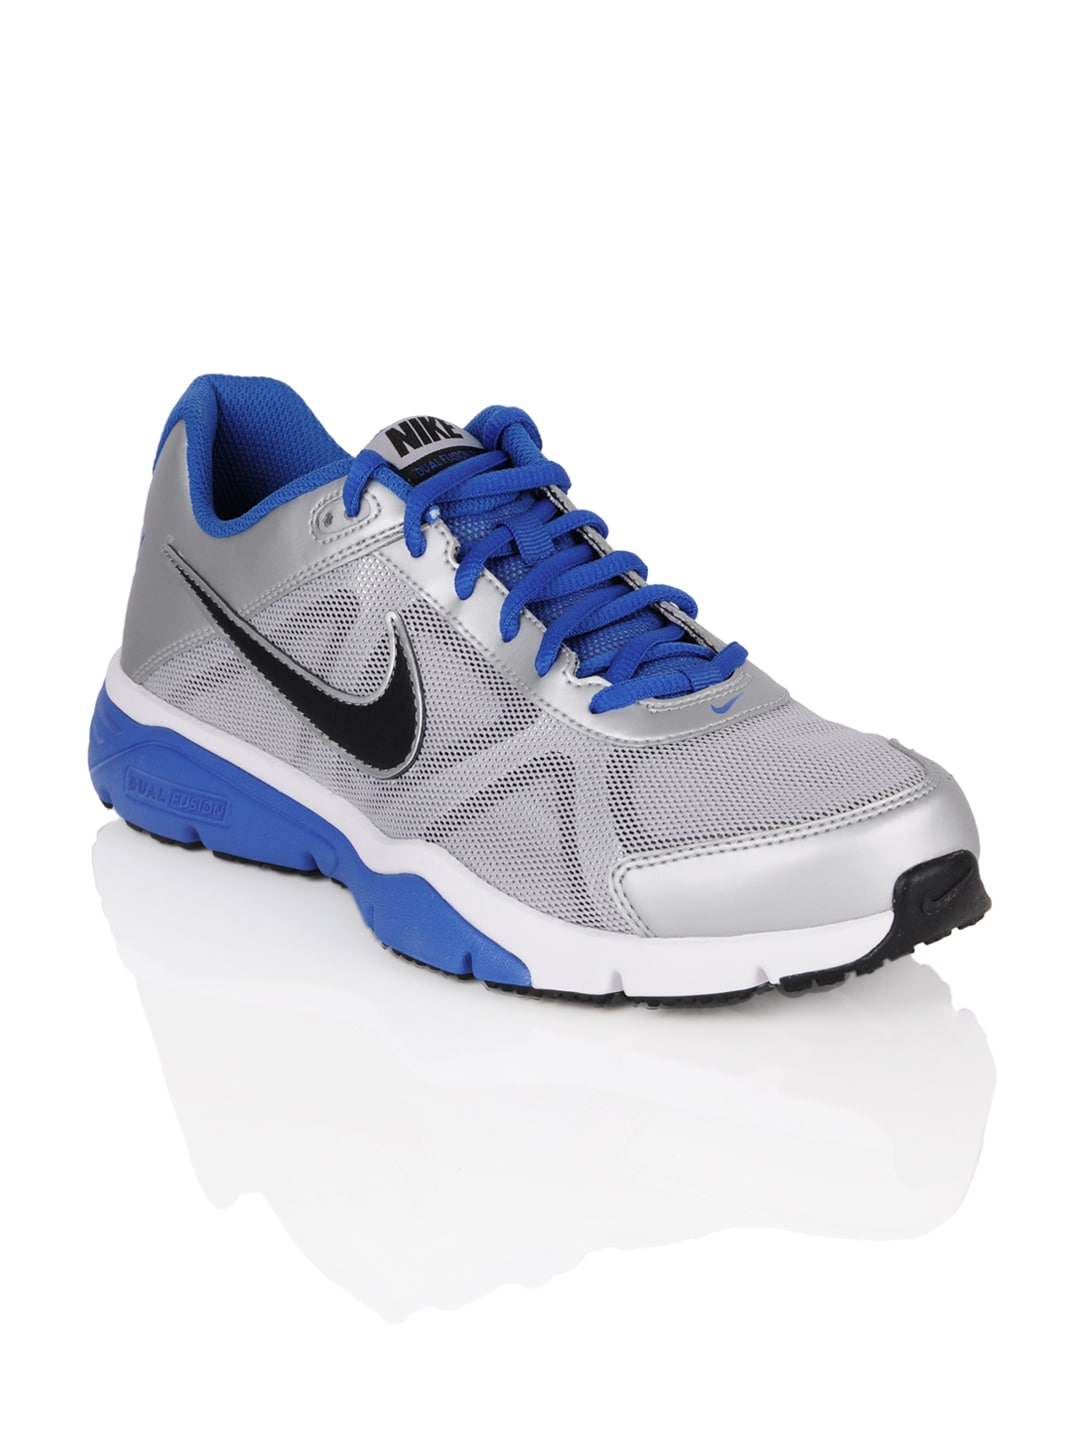

Product Title:  Nike Men Dual Fusion TR III Grey Sports Shoes
Euclidean Distance from input image: 30.953018


In [8]:
# Function to retrieve similar products using CNN-based feature extraction
def get_similar_products_cnn(product_id, num_results):
    # Finding the index of the input product ID in the list of product IDs
    doc_id = Productids.index(product_id)
    
    # Calculating pairwise distances between the input product and all other products
    pairwise_dist = pairwise_distances(extracted_features, extracted_features[doc_id].reshape(1,-1))
    
    # Finding the indices of the most similar products
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]
    # Extracting and displaying the input product image and details
    print("="*20, "input product image", "="*20)
    ip_row = men[['ImageURL','ProductTitle']].loc[men['ProductId']==int(Productids[indices[0]])]
    for indx, row in ip_row.iterrows():
        display(Image(url=row['ImageURL'], width = 224, height = 224, embed=True))
        print('Product Title: ', row['ProductTitle'])
    
    # Displaying the recommended products and their details
    print("\n","="*20, "Recommended products", "="*20)
    for i in range(1,len(indices)):
        rows = men[['ImageURL','ProductTitle']].loc[men['ProductId']==int(Productids[indices[i]])]
        for indx, row in rows.iterrows():
            display(Image(url=row['ImageURL'], width = 224, height = 224, embed=True))
            print('Product Title: ', row['ProductTitle'])
            print('Euclidean Distance from input image:', pdists[i])

# Example: Retrieving 5 similar products for the input product ID '13683'
get_similar_products_cnn('13683', 5)


**NOTE** - The above feature extraction process can be repeated for other genders (Women, Boys and Girls) as well. So let's extract for each one by one.

**For Gender - Women**

In [9]:
# Setting the dimensions for input images
img_width, img_height = 224, 224

# Directory path for training data
train_data_dir = "/kaggle/input/fashion-images/data/Footwear/Women/Images/"

# Number of training samples
nb_train_samples = 769

# Number of training epochs
epochs = 50

# Batch size for training
batch_size = 1

# Function to extract features using a pre-trained ResNet50 model for women's footwear
def extract_features():
    # List to store item codes extracted from file names
    Itemcodes = []
    
    # ImageDataGenerator for preprocessing images
    datagen = ImageDataGenerator(rescale=1. / 255)
    
    # Loading the ResNet50 model without the top layers
    model = applications.ResNet50(include_top=False, weights='imagenet')
    
    # Generating a flow of images from the specified directory
    generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    
    # Extracting item codes from file names
    for i in generator.filenames:
        Itemcodes.append(i[(i.find("/")+1):i.find(".")])
    
    # Predicting features using the ResNet50 model
    extracted_features = model.predict_generator(generator, nb_train_samples // batch_size)
    
    # Reshaping the extracted features
    extracted_features = extracted_features.reshape((769, 100352))
    
    # Saving the extracted features and corresponding item codes as numpy arrays
    np.save(open('./Women_ResNet_features.npy', 'wb'), extracted_features)
    np.save(open('./Women_ResNet_feature_product_ids.npy', 'wb'), np.array(Itemcodes))
    
# Recording the start time
a = datetime.now()

# Calling the feature extraction function
extract_features()

# Printing the time taken for feature extraction
print("Time taken in feature extraction", datetime.now()-a)


Found 769 images belonging to 1 classes.


/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Time taken in feature extraction 0:01:38.403018


**For Gender - Boys**

In [10]:
# Setting the dimensions for input images
img_width, img_height = 224, 224

# Directory path for training data
train_data_dir = "/kaggle/input/fashion-images/data/Apparel/Boys/Images"

# Number of training samples
nb_train_samples = 759

# Number of training epochs
epochs = 50

# Batch size for training
batch_size = 1

# Function to extract features using a pre-trained ResNet50 model for boys' apparel
def extract_features():
    # List to store item codes extracted from file names
    Itemcodes = []
    
    # ImageDataGenerator for preprocessing images
    datagen = ImageDataGenerator(rescale=1. / 255)
    
    # Loading the ResNet50 model without the top layers
    model = applications.ResNet50(include_top=False, weights='imagenet')
    
    # Generating a flow of images from the specified directory
    generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    
    # Extracting item codes from file names
    for i in generator.filenames:
        Itemcodes.append(i[(i.find("/")+1):i.find(".")])
    
    # Predicting features using the ResNet50 model
    extracted_features = model.predict_generator(generator, nb_train_samples // batch_size)
    
    # Reshaping the extracted features
    extracted_features = extracted_features.reshape((759, 100352))
    
    # Saving the extracted features and corresponding item codes as numpy arrays
    np.save(open('./Boys_ResNet_features.npy', 'wb'), extracted_features)
    np.save(open('./Boys_ResNet_feature_product_ids.npy', 'wb'), np.array(Itemcodes))
    
# Recording the start time
a = datetime.now()

# Calling the feature extraction function
extract_features()

# Printing the time taken for feature extraction
print("Time taken in feature extraction", datetime.now()-a)


Found 759 images belonging to 1 classes.
Time taken in feature extraction 0:01:41.360445


**For Gender - Girls**

In [11]:
# Setting the dimensions for input images
img_width, img_height = 224, 224

# Directory path for training data
train_data_dir = "/kaggle/input/fashion-images/data/Apparel/Girls/Images"

# Number of training samples
nb_train_samples = 567

# Number of training epochs
epochs = 50

# Batch size for training
batch_size = 1

# Function to extract features using a pre-trained ResNet50 model for girls' apparel
def extract_features():
    # List to store item codes extracted from file names
    Itemcodes = []
    
    # ImageDataGenerator for preprocessing images
    datagen = ImageDataGenerator(rescale=1. / 255)
    
    # Loading the ResNet50 model without the top layers
    model = applications.ResNet50(include_top=False, weights='imagenet')
    
    # Generating a flow of images from the specified directory
    generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    
    # Extracting item codes from file names
    for i in generator.filenames:
        Itemcodes.append(i[(i.find("/")+1):i.find(".")])
    
    # Predicting features using the ResNet50 model
    extracted_features = model.predict_generator(generator, nb_train_samples // batch_size)
    
    # Reshaping the extracted features
    extracted_features = extracted_features.reshape((567, 100352))
    
    # Saving the extracted features and corresponding item codes as numpy arrays
    np.save(open('./Girls_ResNet_features.npy', 'wb'), extracted_features)
    np.save(open('./Girls_ResNet_feature_product_ids.npy', 'wb'), np.array(Itemcodes))
    
# Recording the start time
a = datetime.now()

# Calling the feature extraction function
extract_features()

# Printing the time taken for feature extraction
print("Time taken in feature extraction", datetime.now()-a)


Found 567 images belonging to 1 classes.
Time taken in feature extraction 0:01:15.731647


### 5. Deploying the solution

In [12]:
# Loading previously saved extracted features and corresponding product IDs for boys' apparel
boys_extracted_features = np.load('/kaggle/working/Boys_ResNet_features.npy')
boys_Productids = np.load('/kaggle/working/Boys_ResNet_feature_product_ids.npy')

# Loading previously saved extracted features and corresponding product IDs for girls' apparel
girls_extracted_features = np.load('/kaggle/working/Girls_ResNet_features.npy')
girls_Productids = np.load('/kaggle/working/Girls_ResNet_feature_product_ids.npy')

# Loading previously saved extracted features and corresponding product IDs for men's footwear
men_extracted_features = np.load('/kaggle/working/Men_ResNet_features.npy')
men_Productids = np.load('/kaggle/working/Men_ResNet_feature_product_ids.npy')

# Loading previously saved extracted features and corresponding product IDs for women's footwear
women_extracted_features = np.load('/kaggle/working/Women_ResNet_features.npy')
women_Productids = np.load('/kaggle/working/Women_ResNet_feature_product_ids.npy')

# Converting the 'ProductId' column in the 'fashion_df' DataFrame to string type
fashion_df["ProductId"] = fashion_df["ProductId"].astype(str)


In [16]:
# Function to retrieve similar products using CNN-based feature extraction
def get_similar_products_cnn(product_id, num_results):
    # Determining the gender category of the input product
    gender_category = fashion_df[fashion_df['ProductId'] == product_id]['Gender'].values[0]
    
    # Selecting the appropriate set of pre-extracted features and product IDs based on the gender category
    if gender_category == "Boys":
        extracted_features = boys_extracted_features
        Productids = boys_Productids
    elif gender_category == "Girls":
        extracted_features = girls_extracted_features
        Productids = girls_Productids
    elif gender_category == "Men":
        extracted_features = men_extracted_features
        Productids = men_Productids
    elif gender_category == "Women":
        extracted_features = women_extracted_features
        Productids = women_Productids
    
    # Converting the product IDs to a list
    Productids = list(Productids)
    
    # Finding the index of the input product ID in the list of product IDs
    doc_id = Productids.index(product_id)
    
    # Calculating pairwise distances between the input product and all other products
    pairwise_dist = pairwise_distances(extracted_features, extracted_features[doc_id].reshape(1,-1))
    
    # Finding the indices of the most similar products
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]
    # Extracting and displaying the input product image and details
    print("="*20, "input product details", "="*20)
    ip_row = fashion_df[['ImageURL','ProductTitle']].loc[fashion_df['ProductId']==Productids[indices[0]]]
    for indx, row in ip_row.iterrows():
        display(Image(url=row['ImageURL'], width = 224, height = 224, embed=True))
        print('Product Title: ', row['ProductTitle'])
    
    # Displaying the recommended products and their details
    print("\n","="*20, "Recommended products", "="*20)
    for i in range(1,len(indices)):
        rows = fashion_df[['ImageURL','ProductTitle']].loc[fashion_df['ProductId']==Productids[indices[i]]]
        for indx, row in rows.iterrows():
            display(Image(url=row['ImageURL'], width = 224, height = 224, embed=True))
            print('Product Title: ', row['ProductTitle'])
            print('Euclidean Distance from input image:', pdists[i])


==================== input product details ====================


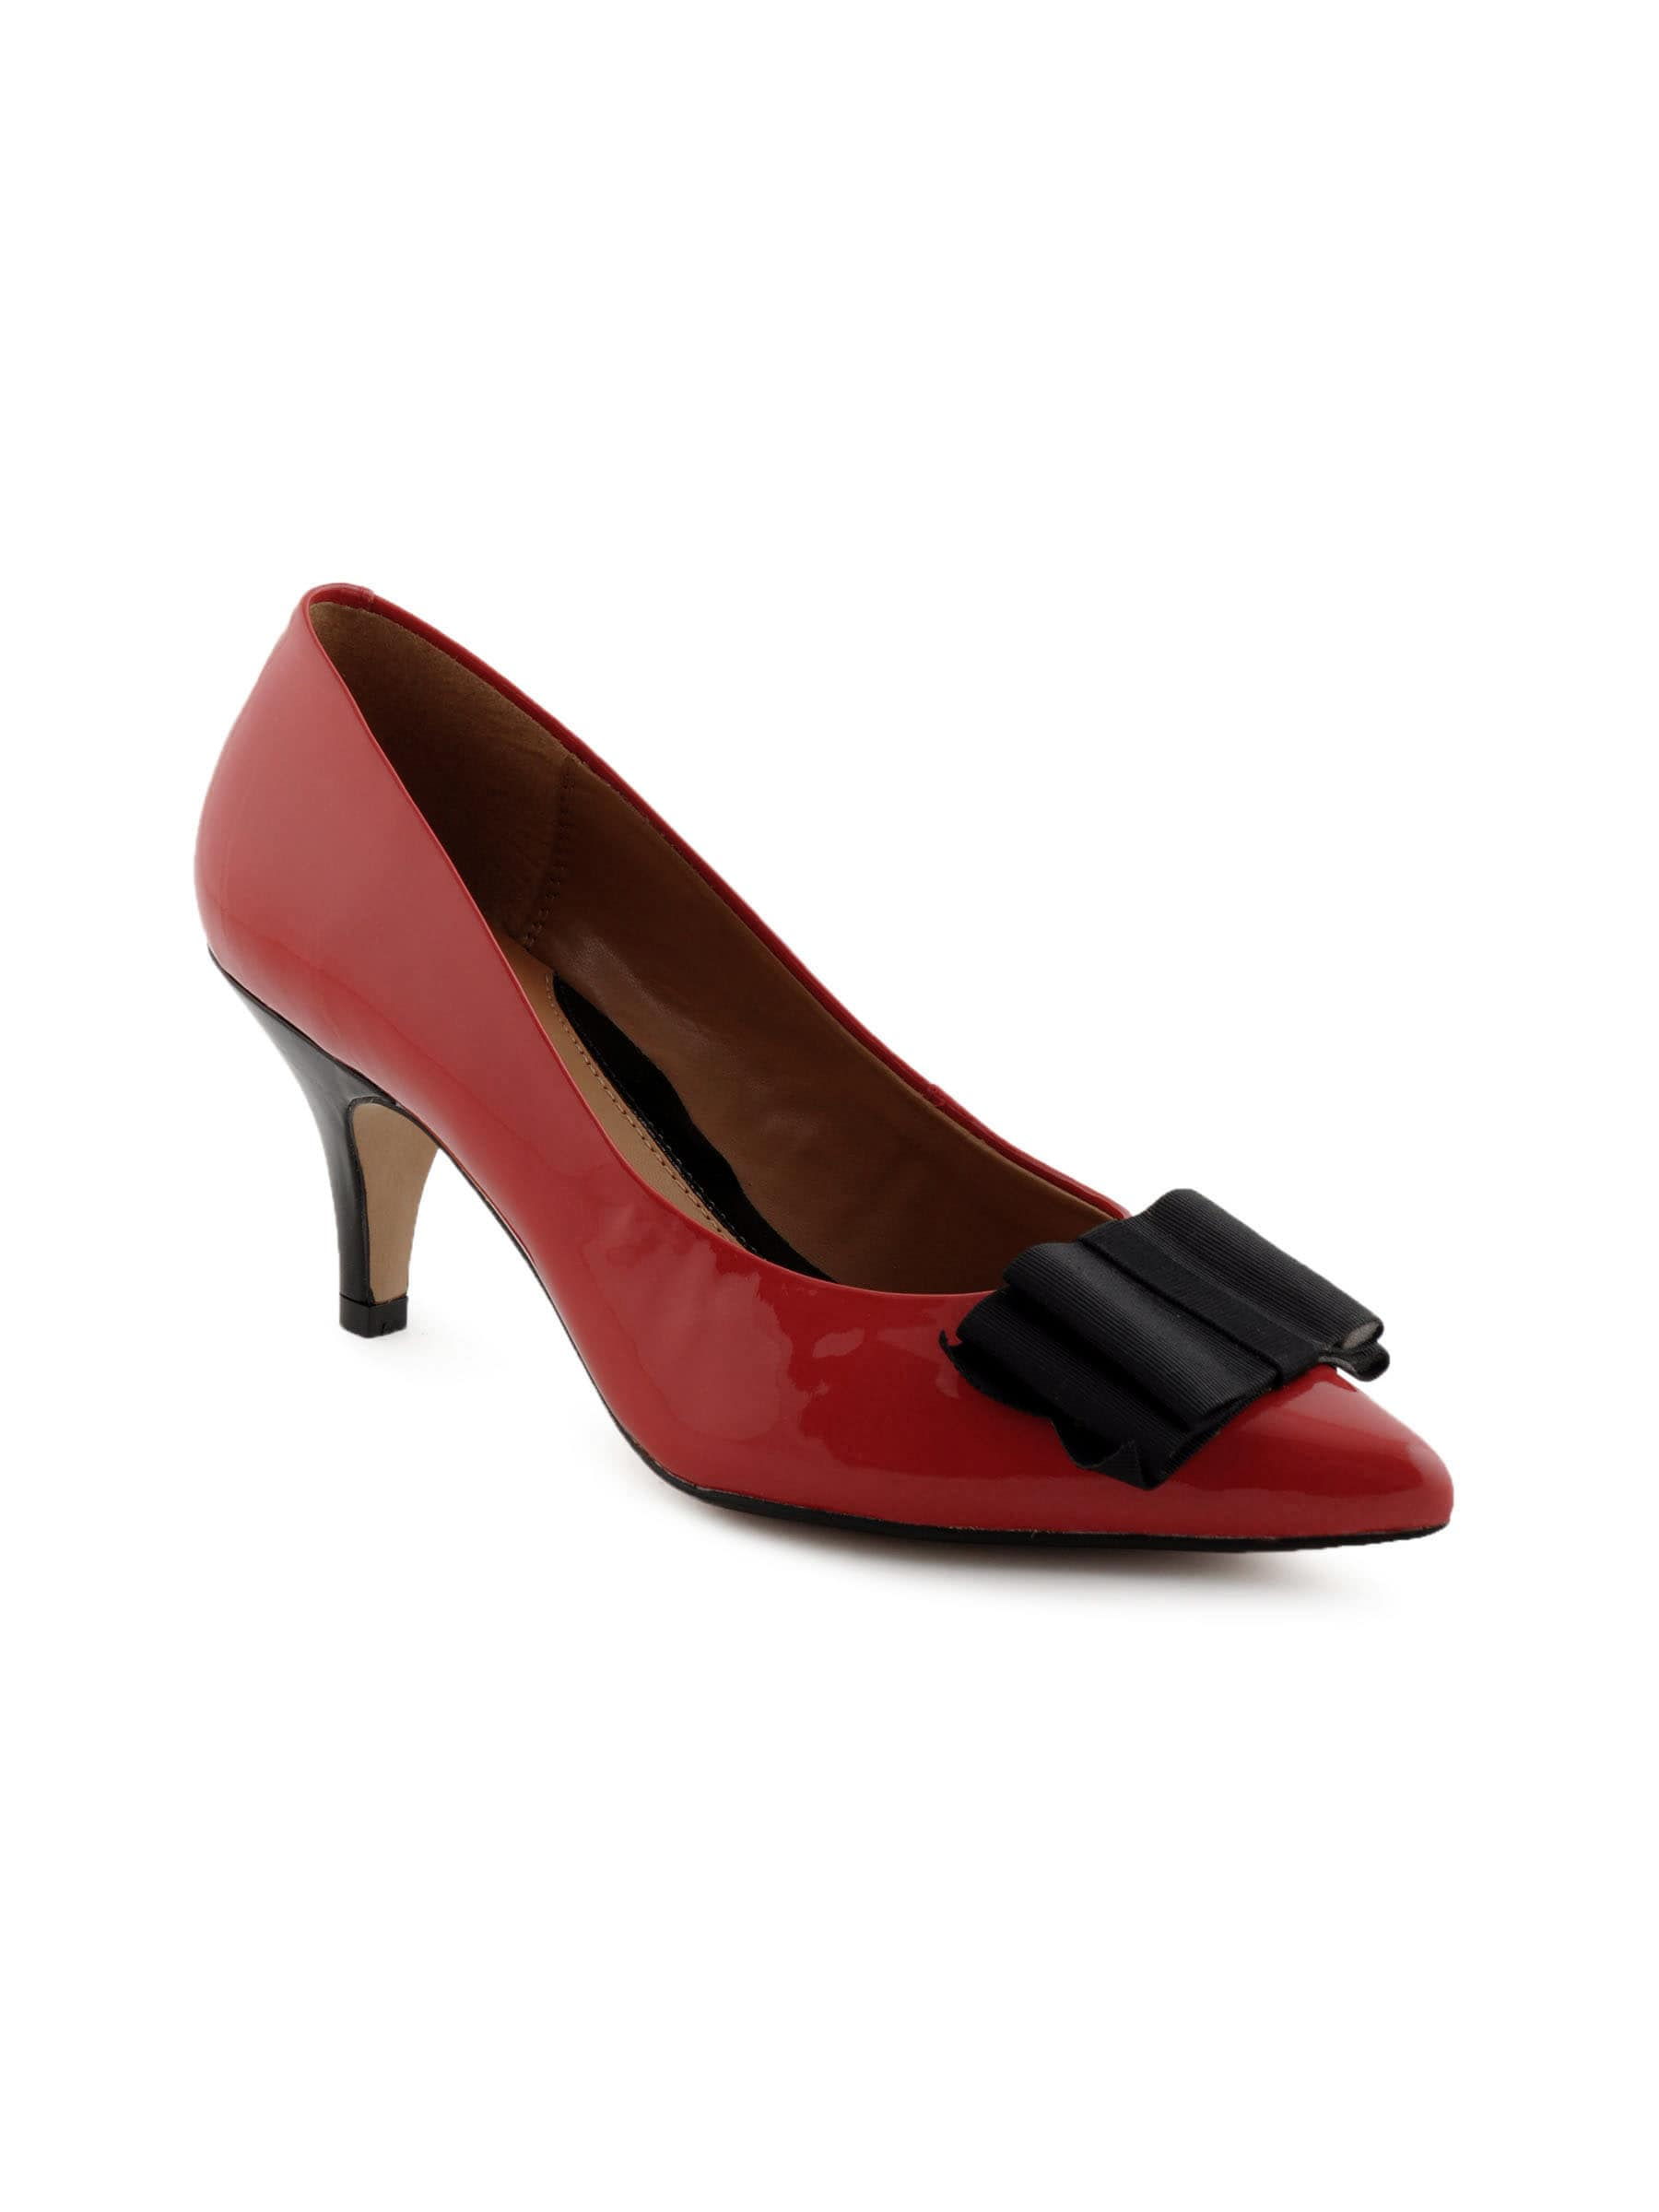

Product Title:  Clarks Women Balti Zing Red Heels

 ==================== Recommended products ====================


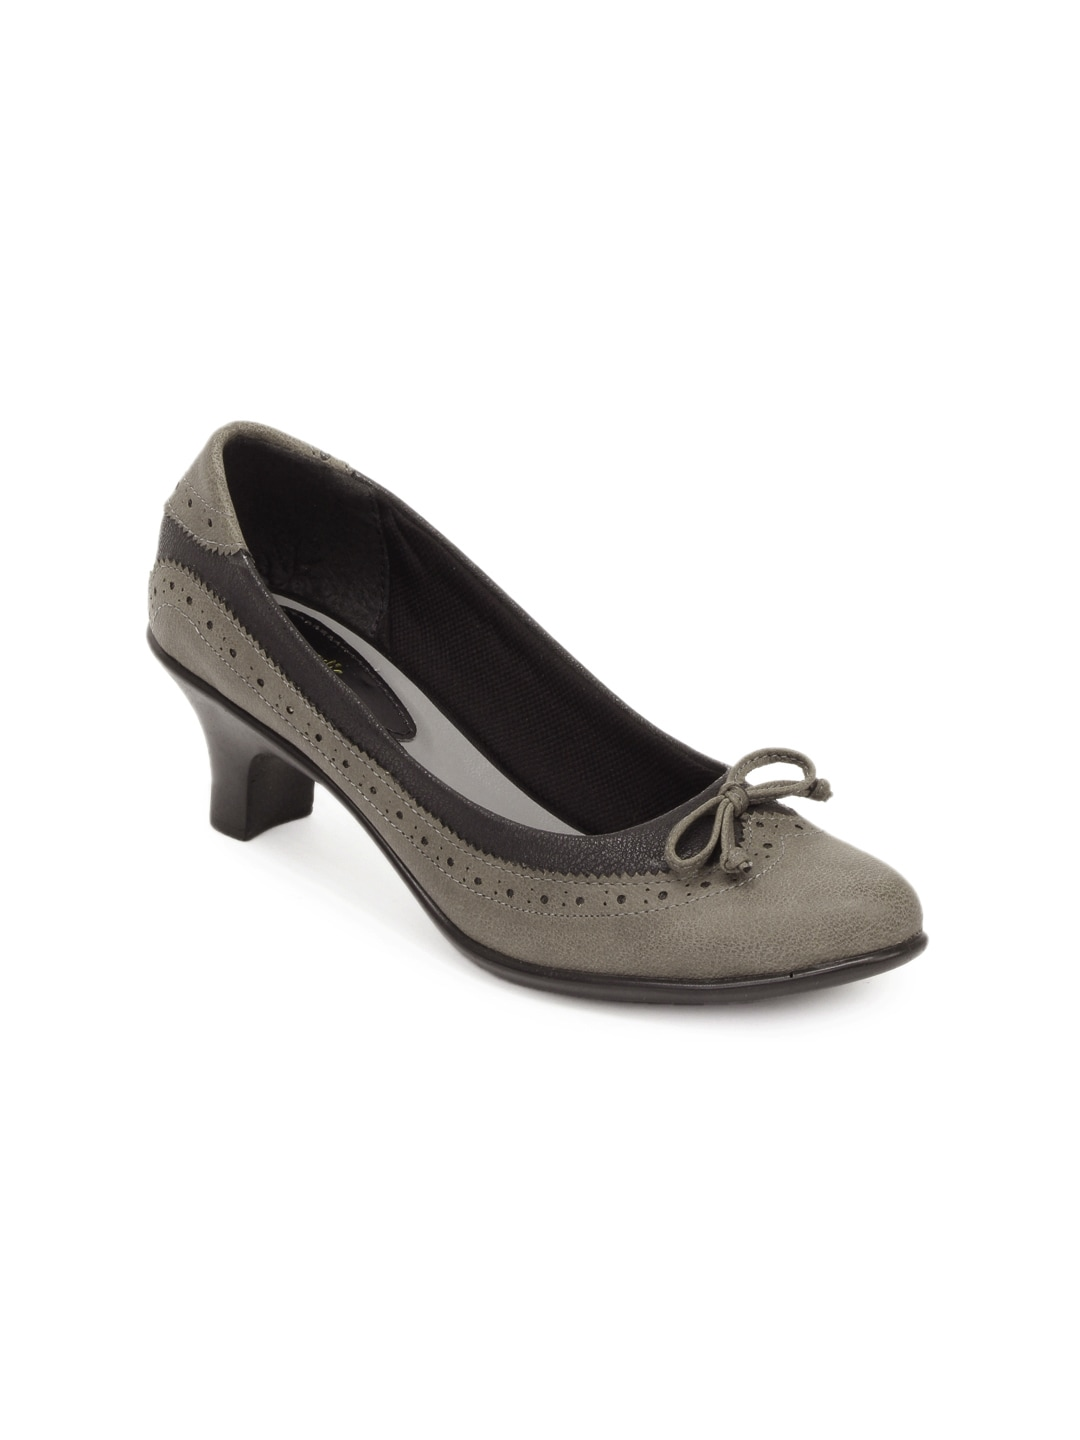

Product Title:  Catwalk Women Black & Grey Heels
Euclidean Distance from input image: 41.730297


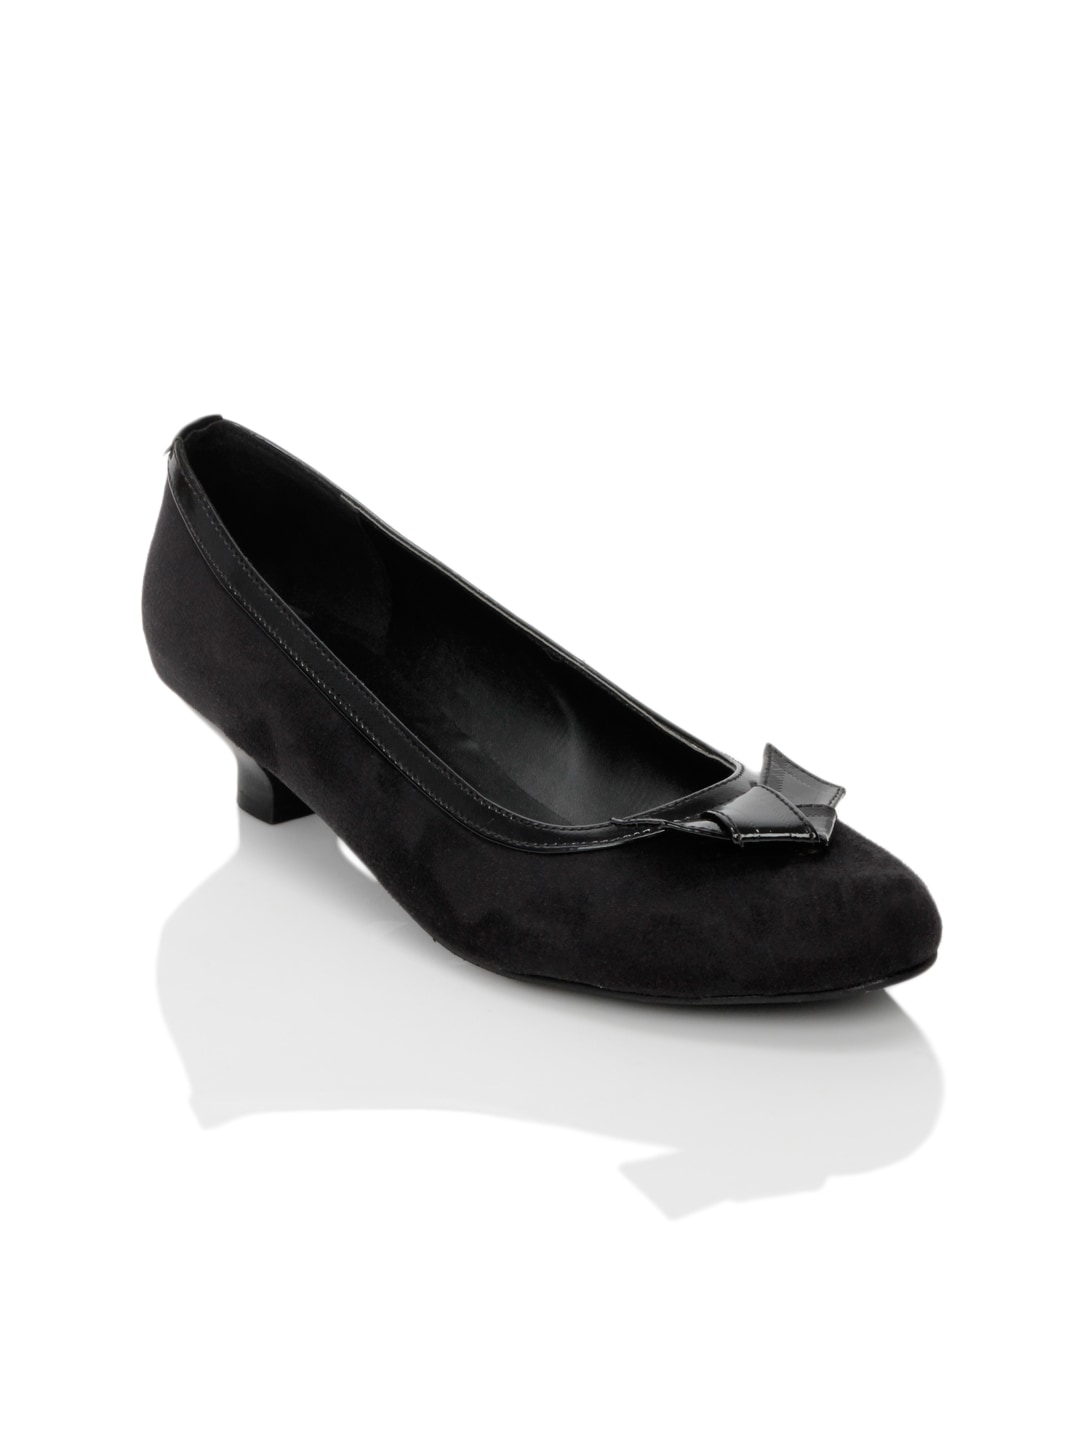

Product Title:  Rocia Women Black Shoes
Euclidean Distance from input image: 44.681526


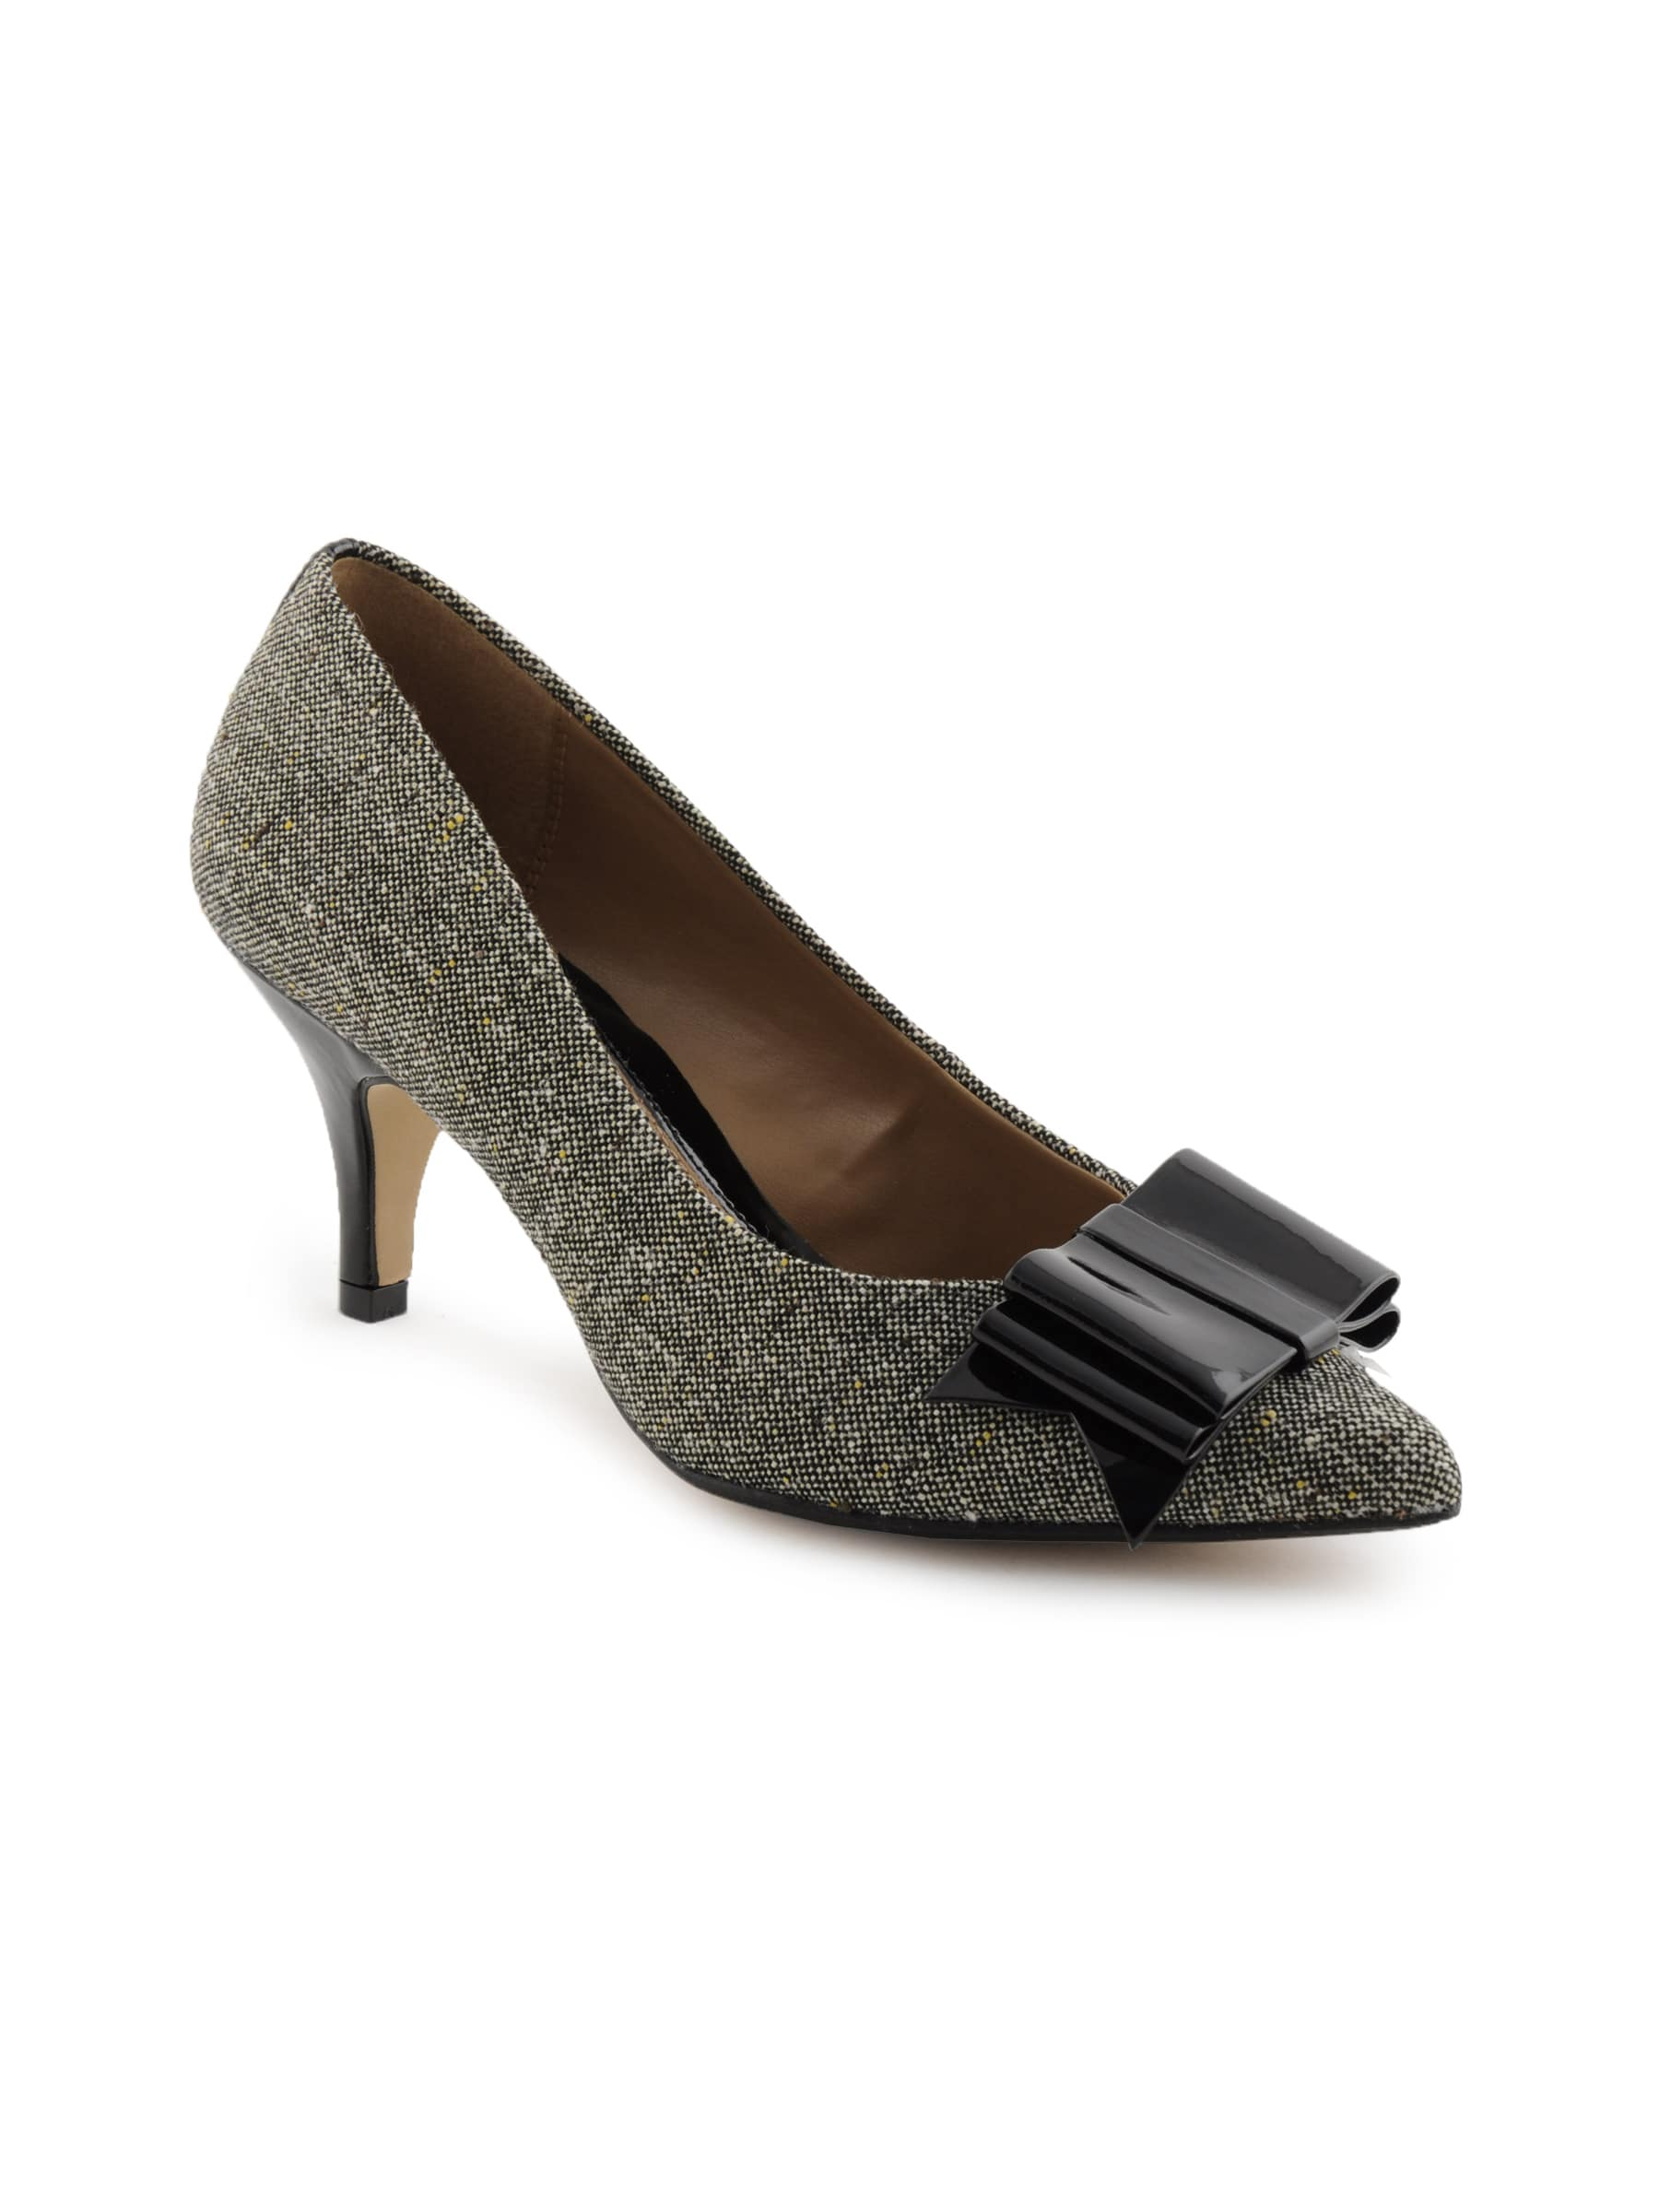

Product Title:  Clarks Women Balti Zing Black Heels
Euclidean Distance from input image: 45.083565


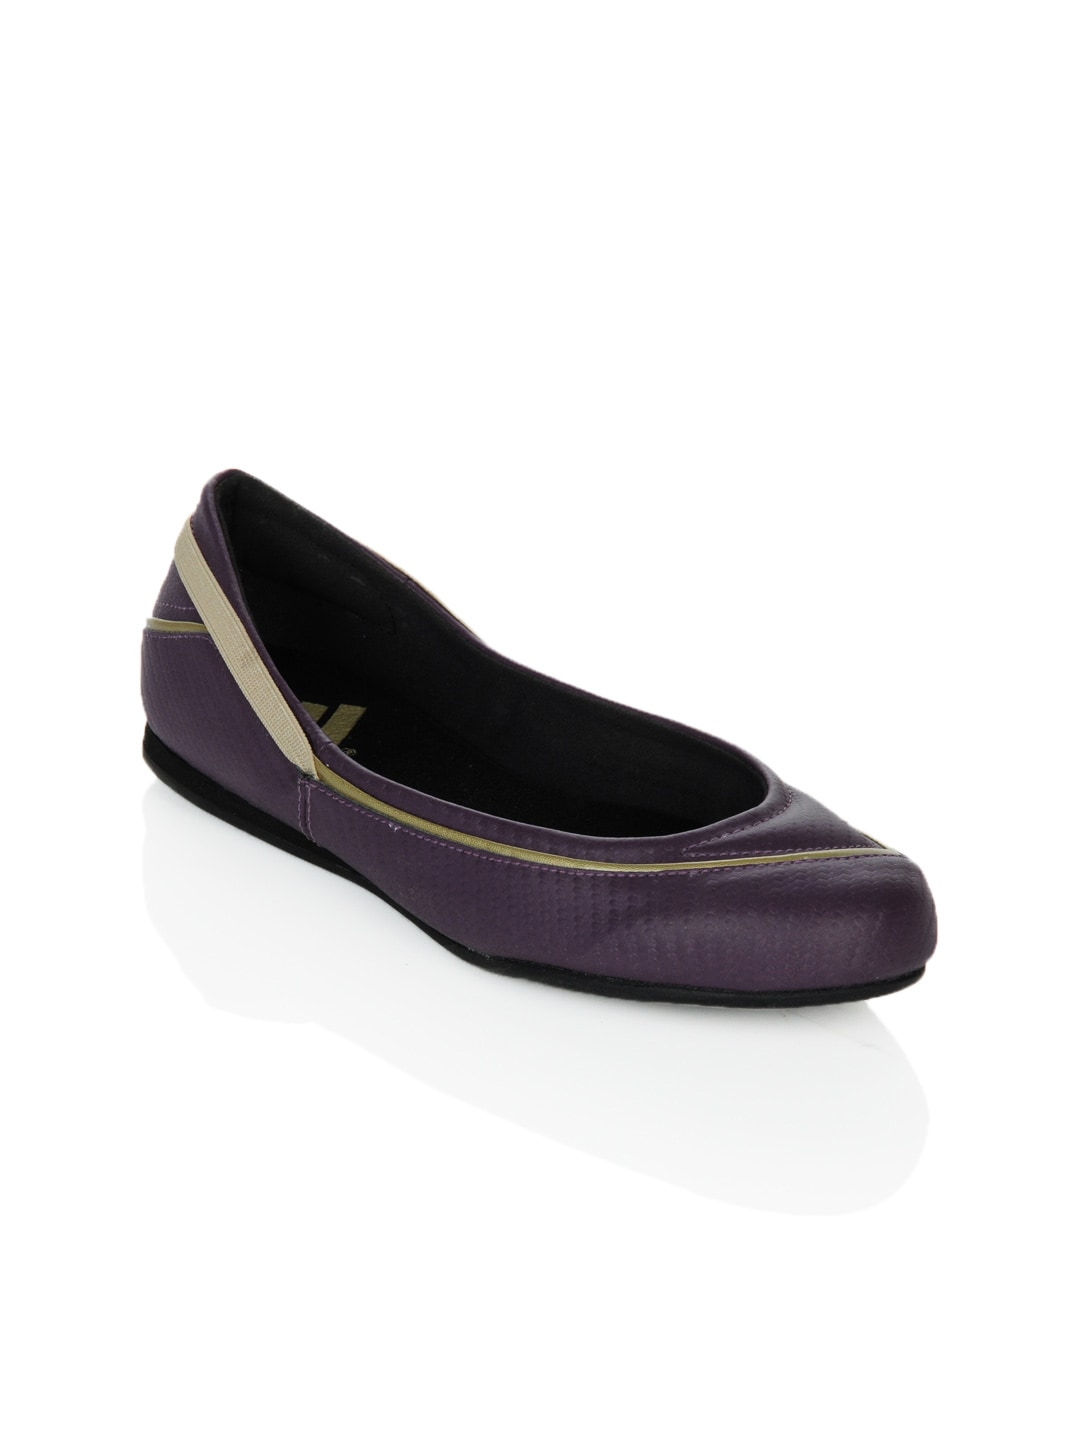

Product Title:  ADIDAS Women Ballerina Purple Shoes
Euclidean Distance from input image: 46.138386


In [17]:
get_similar_products_cnn('21030', 5)

==================== input product details ====================


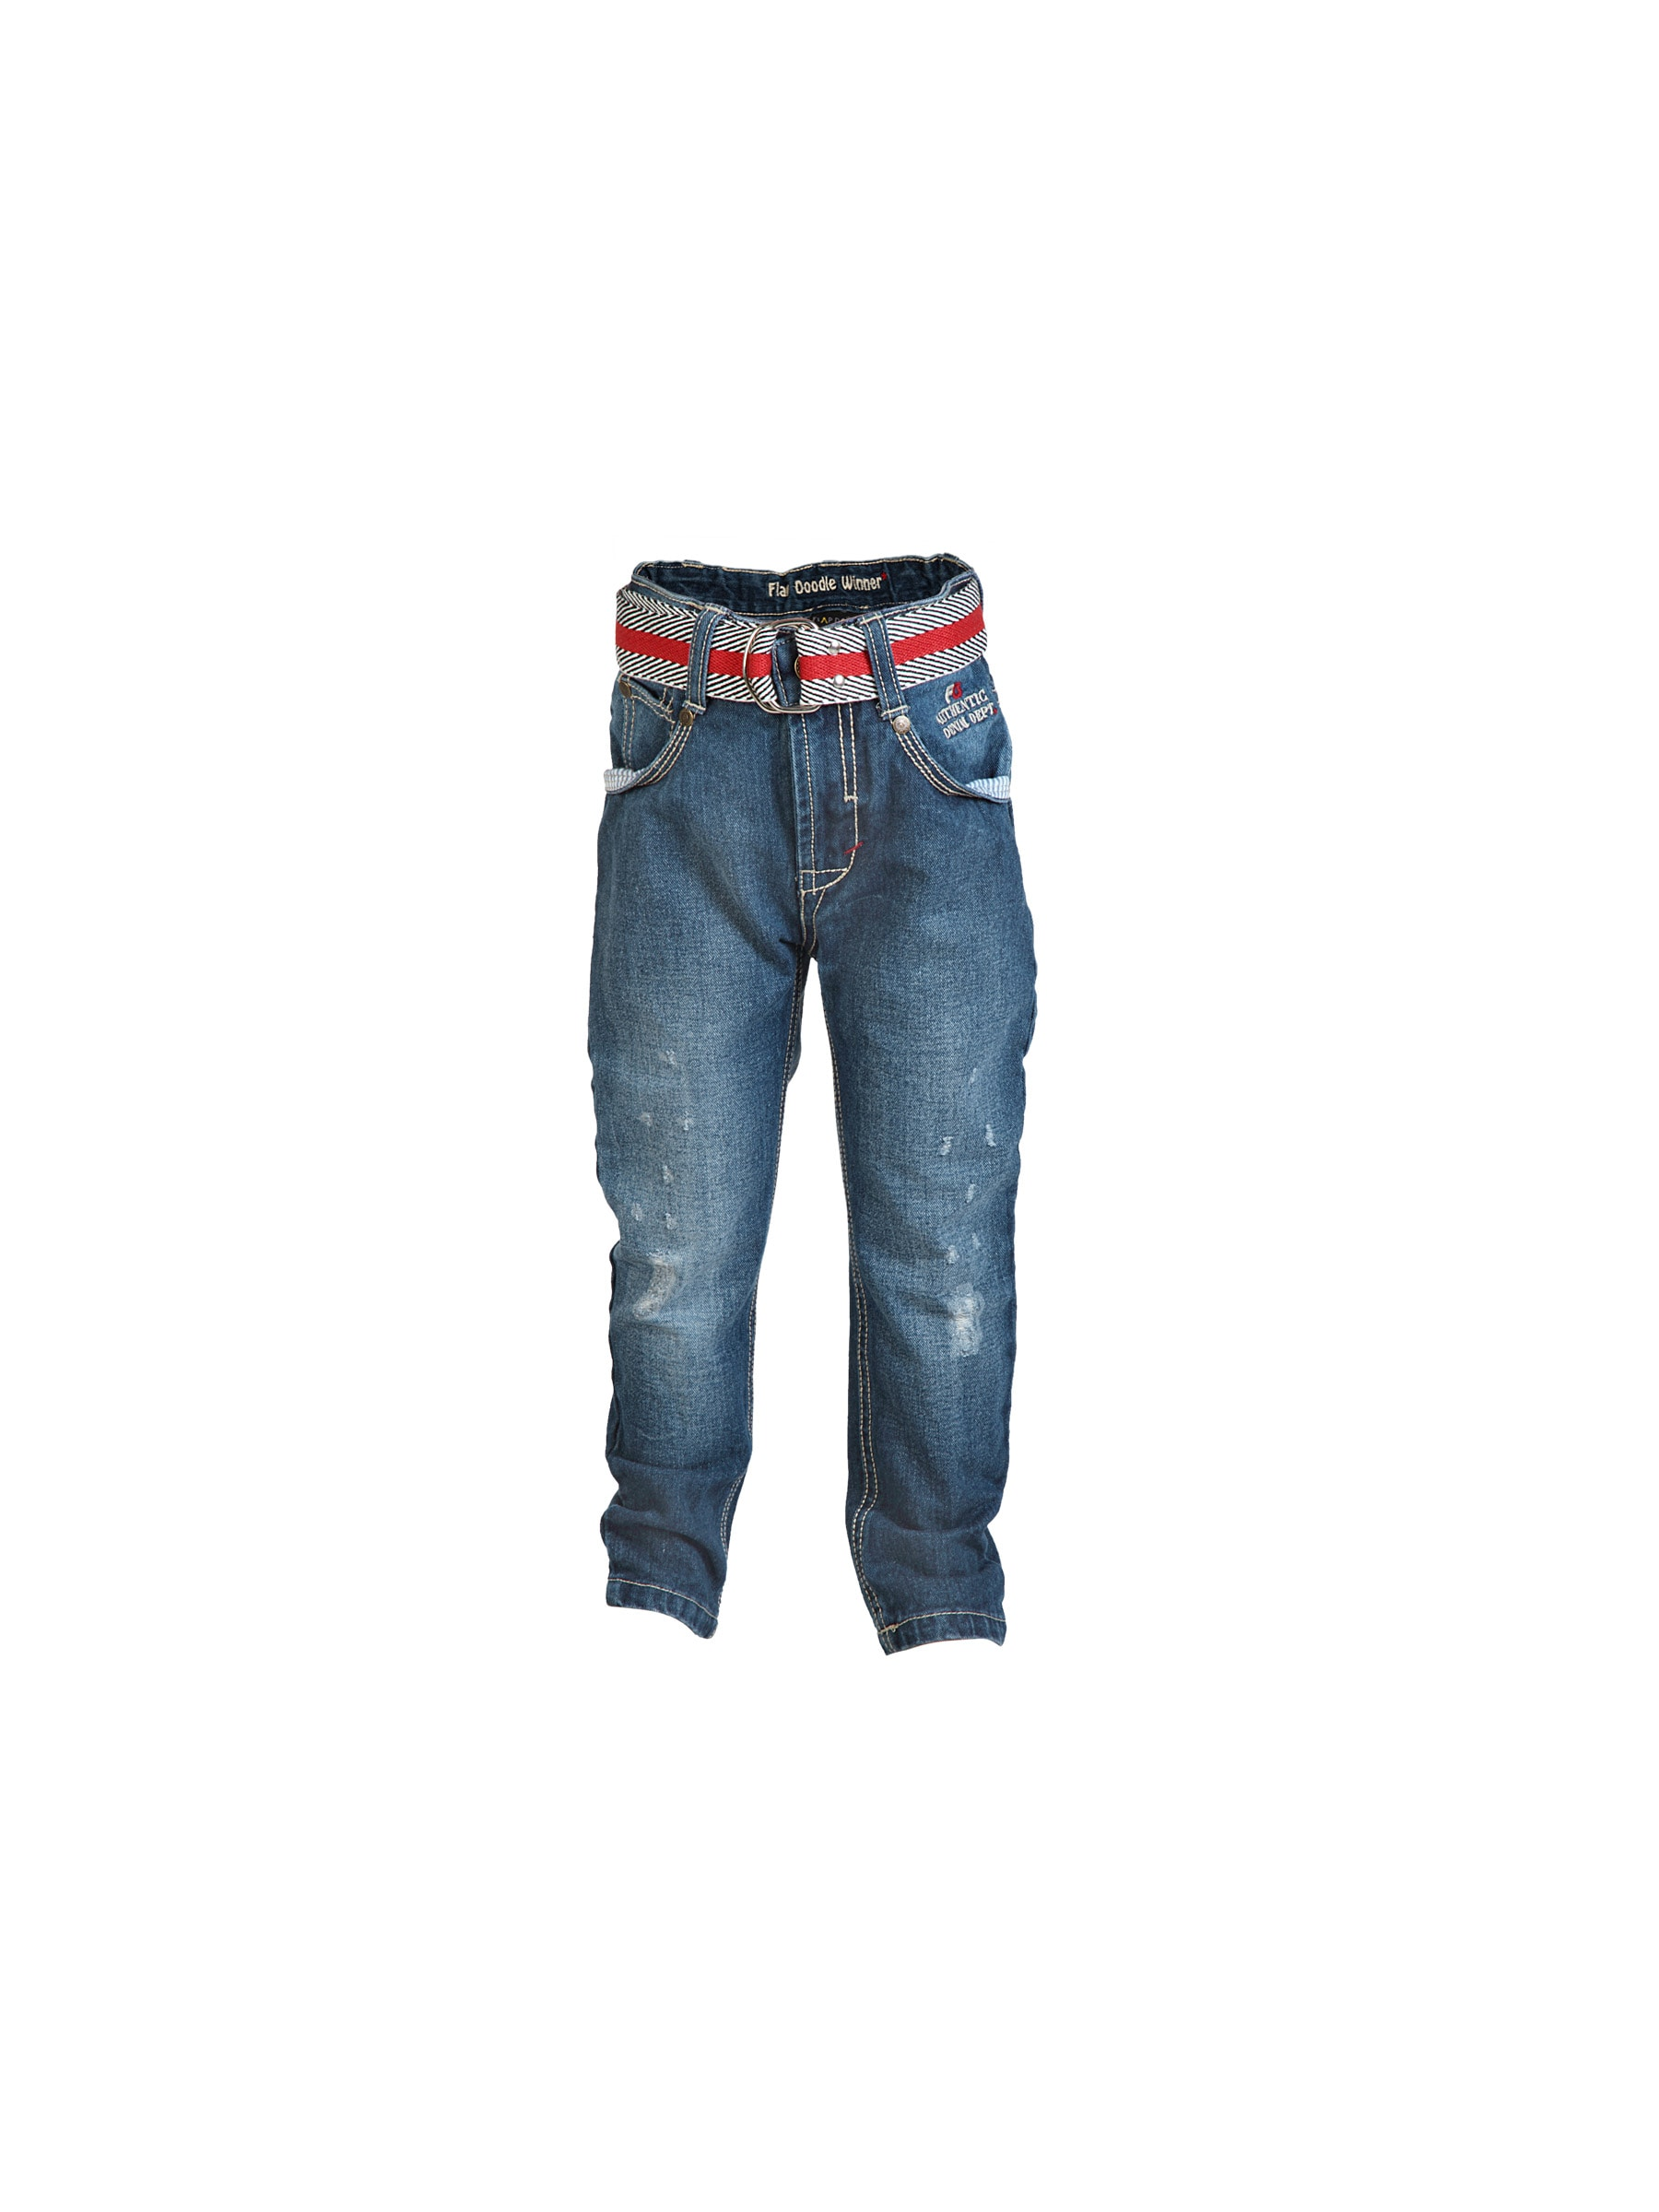

Product Title:  Doodle Boys-Boys Washed Blue Jeans

 ==================== Recommended products ====================


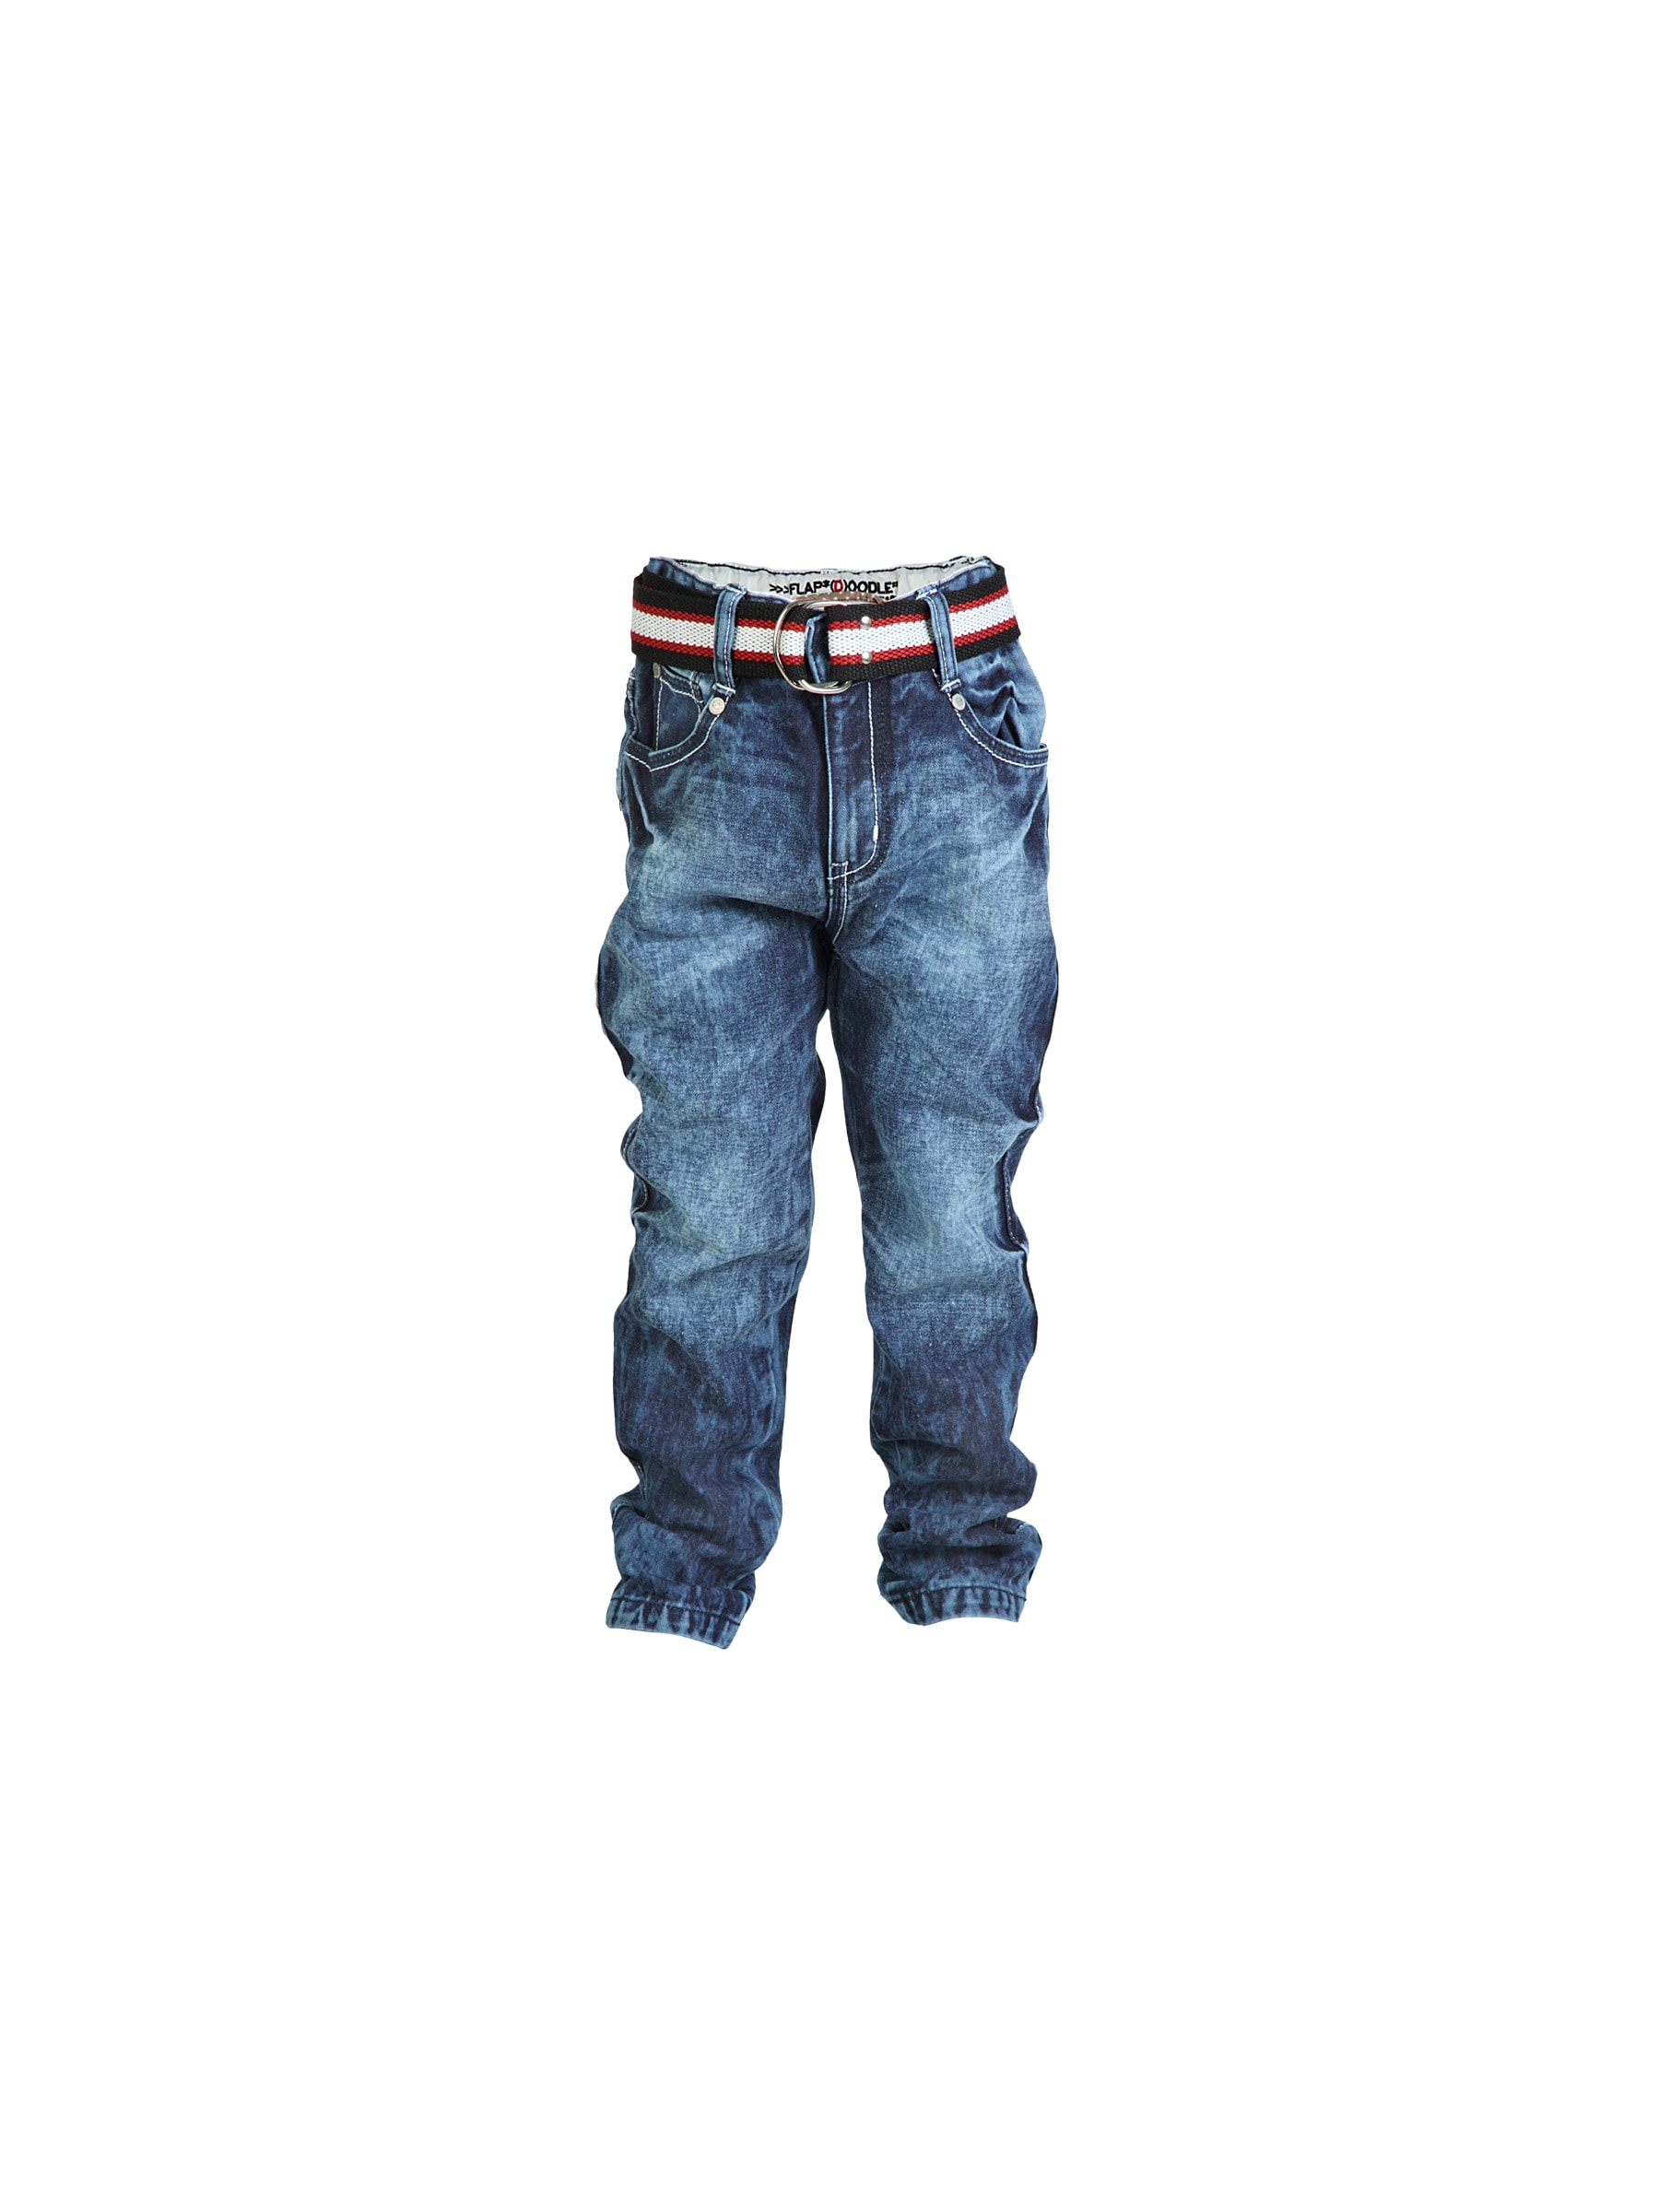

Product Title:  Doodle Boys-Boys Acid Wash Blue Jeans
Euclidean Distance from input image: 19.700968


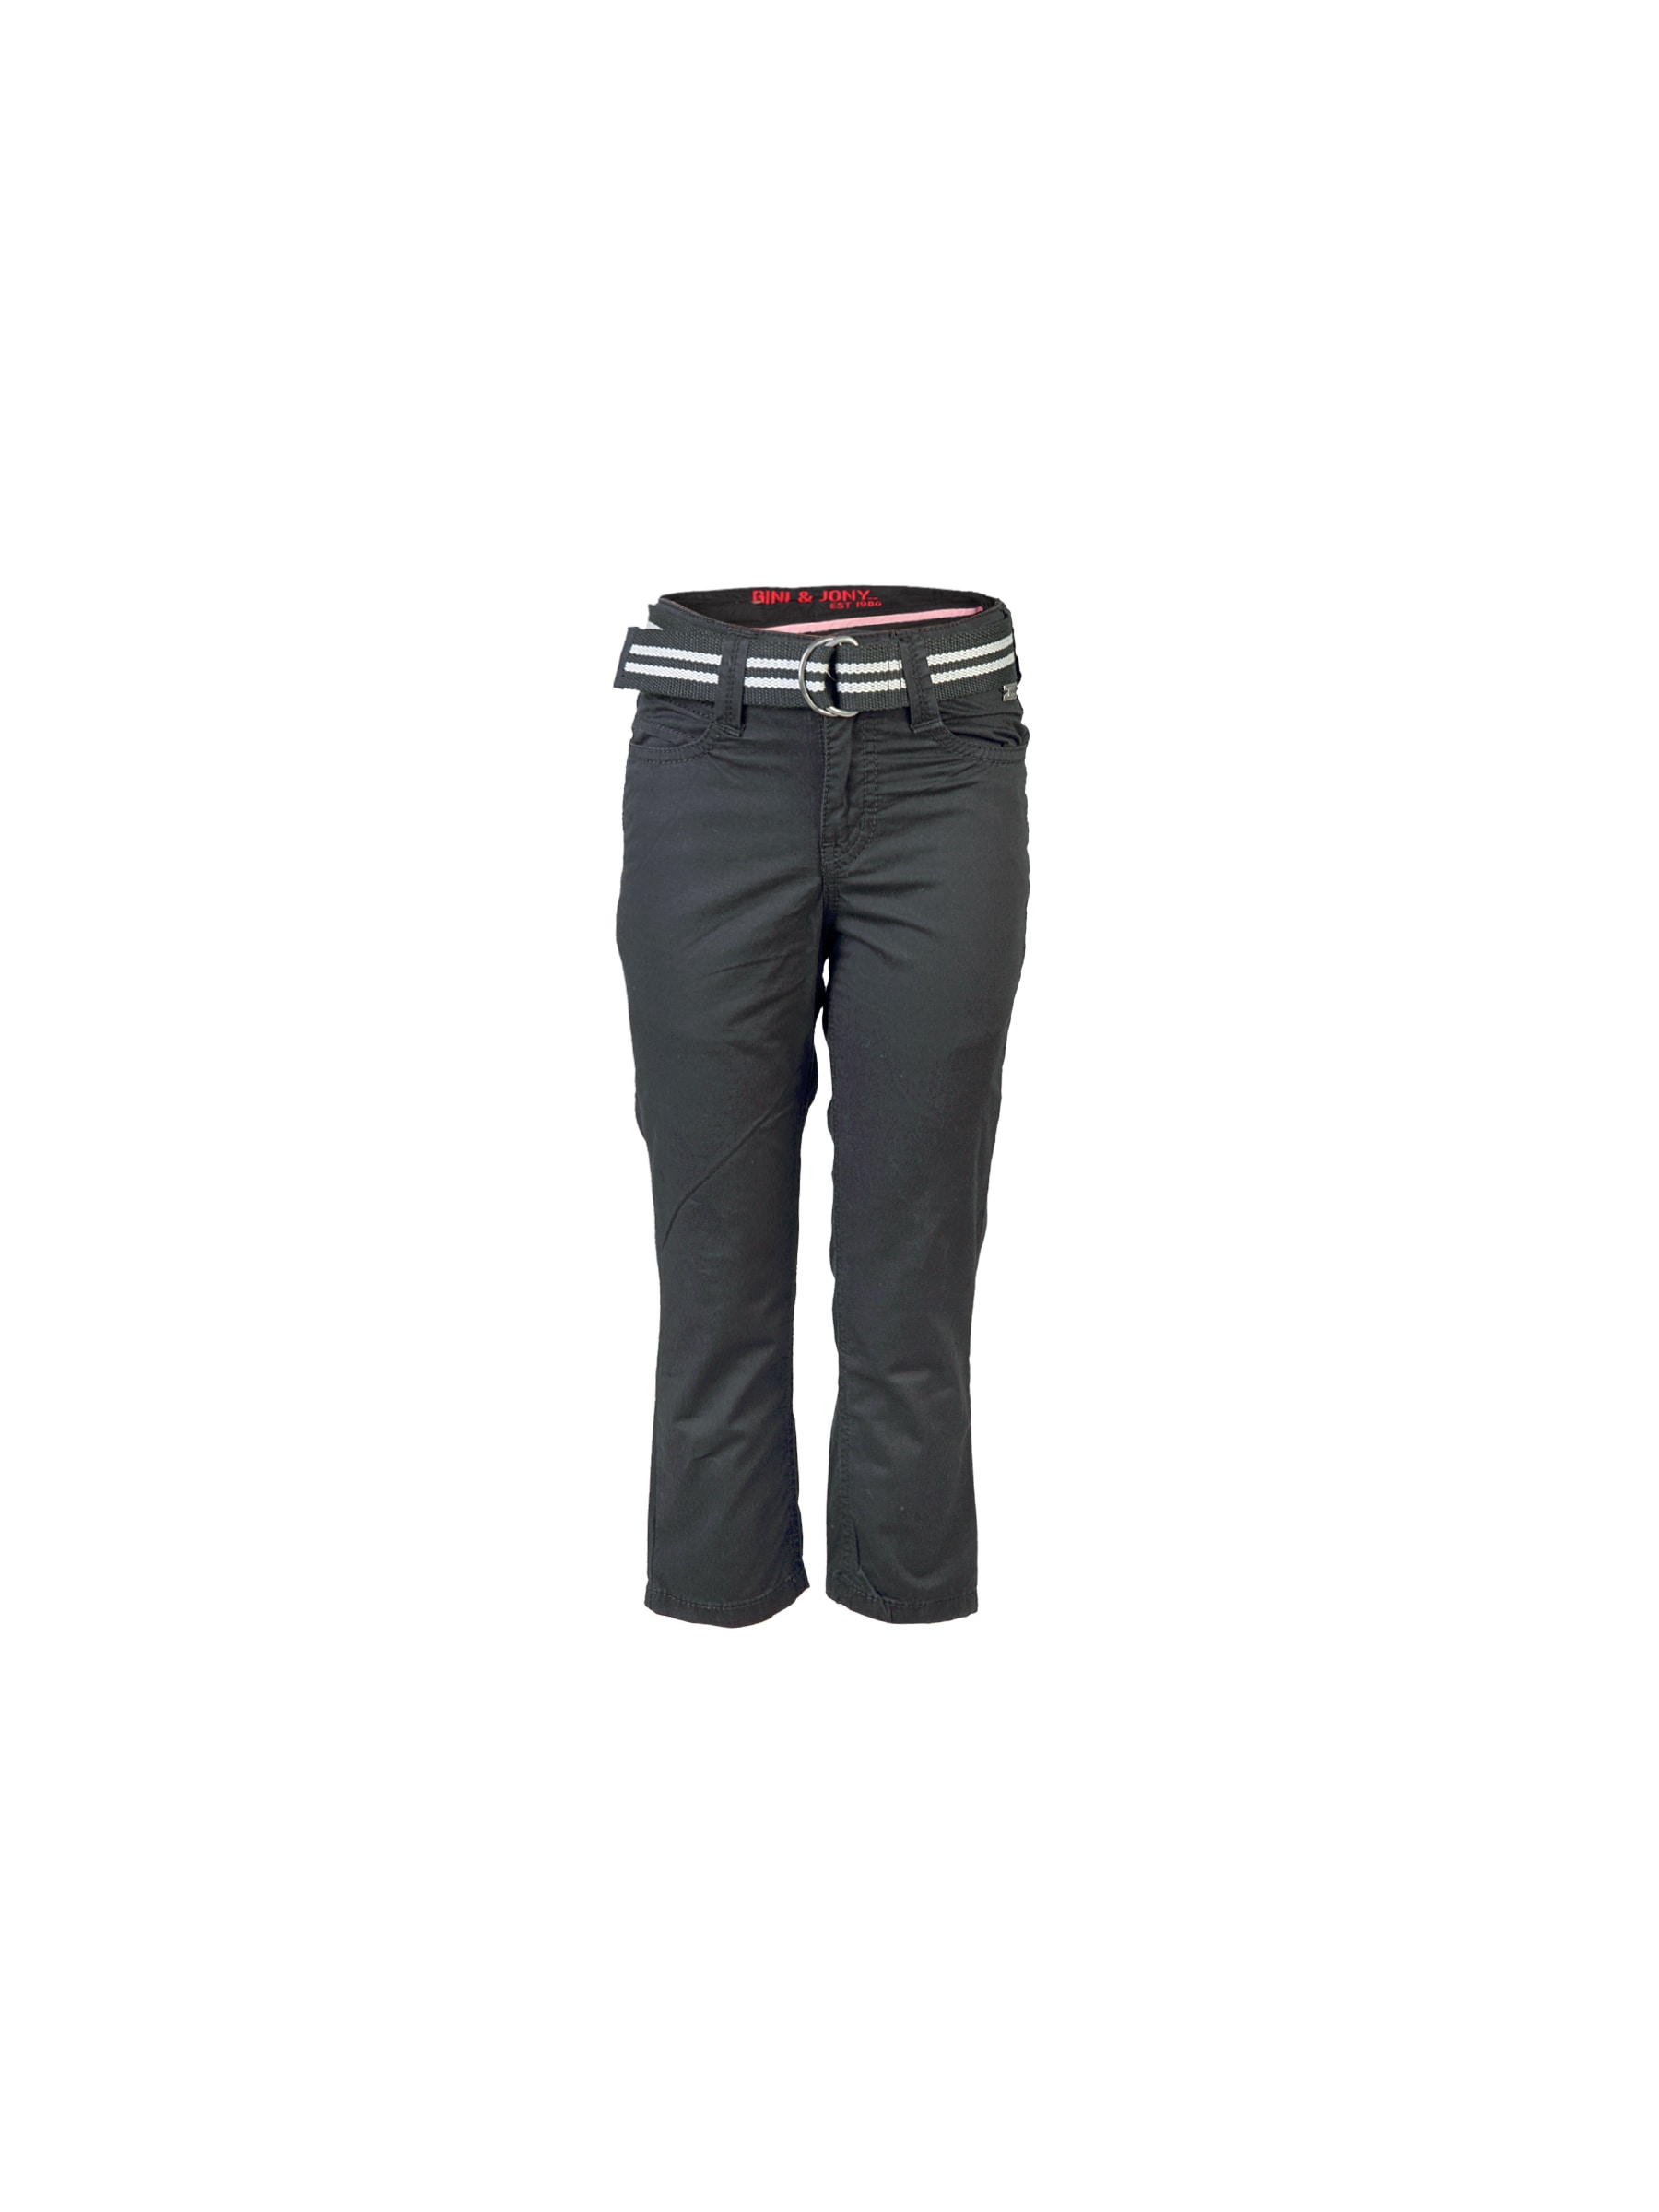

Product Title:  Gini and Jony Kids Solid Black Trousers
Euclidean Distance from input image: 28.43107


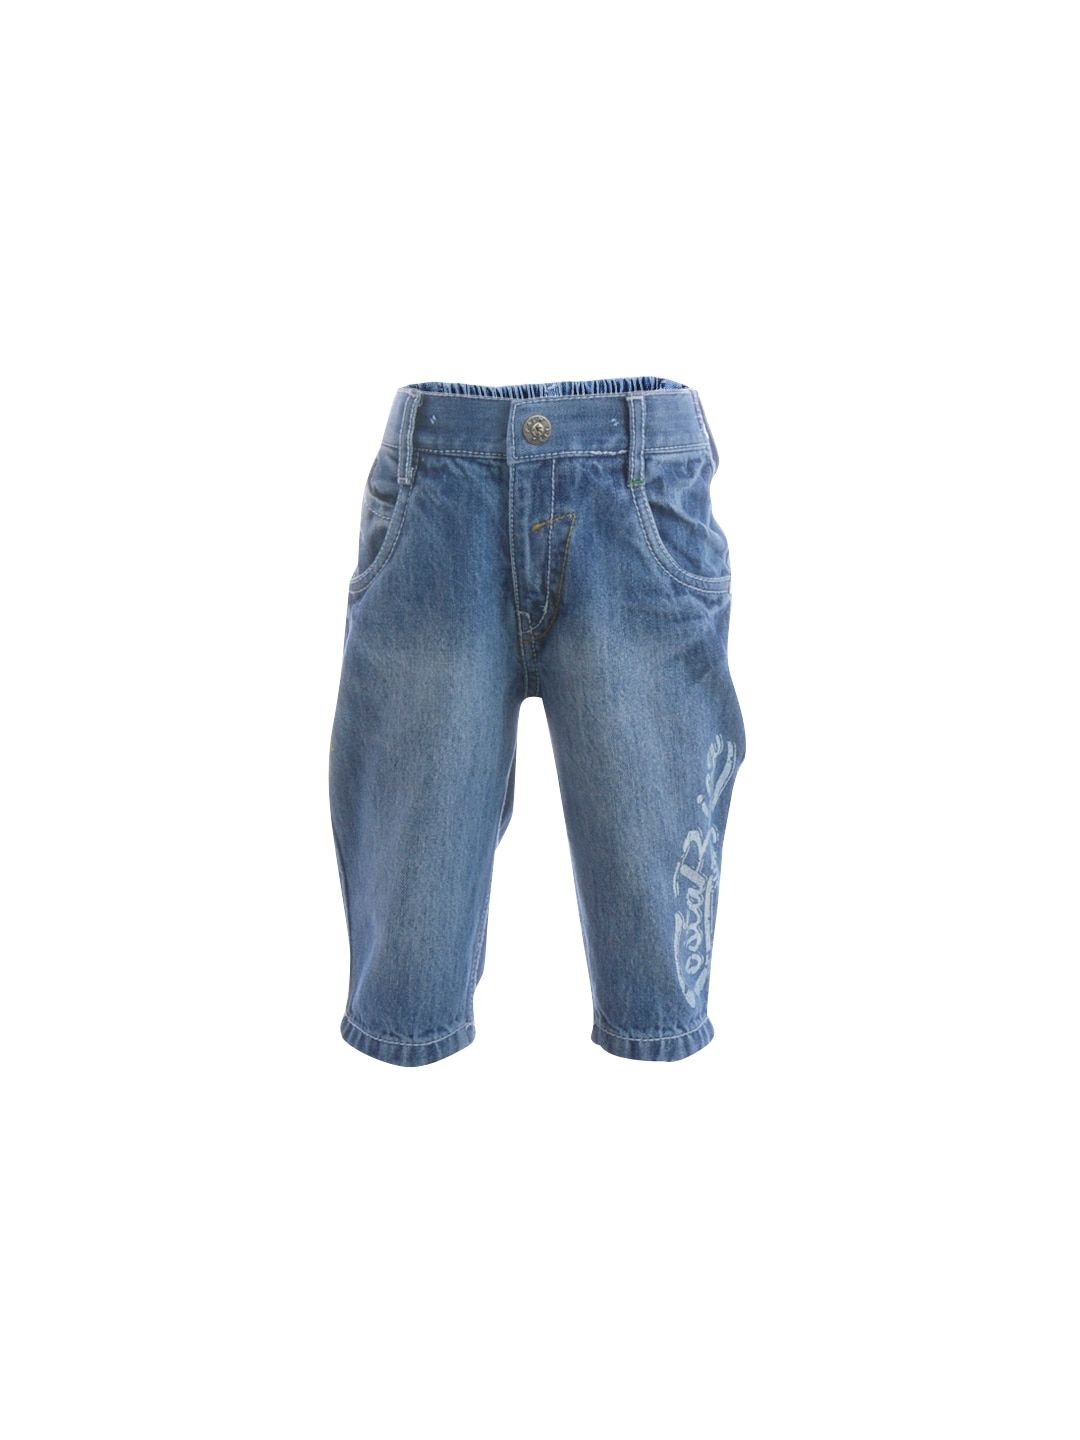

Product Title:  Palm Tree Boys Washed Blue 3/4 Length Pants
Euclidean Distance from input image: 28.973797


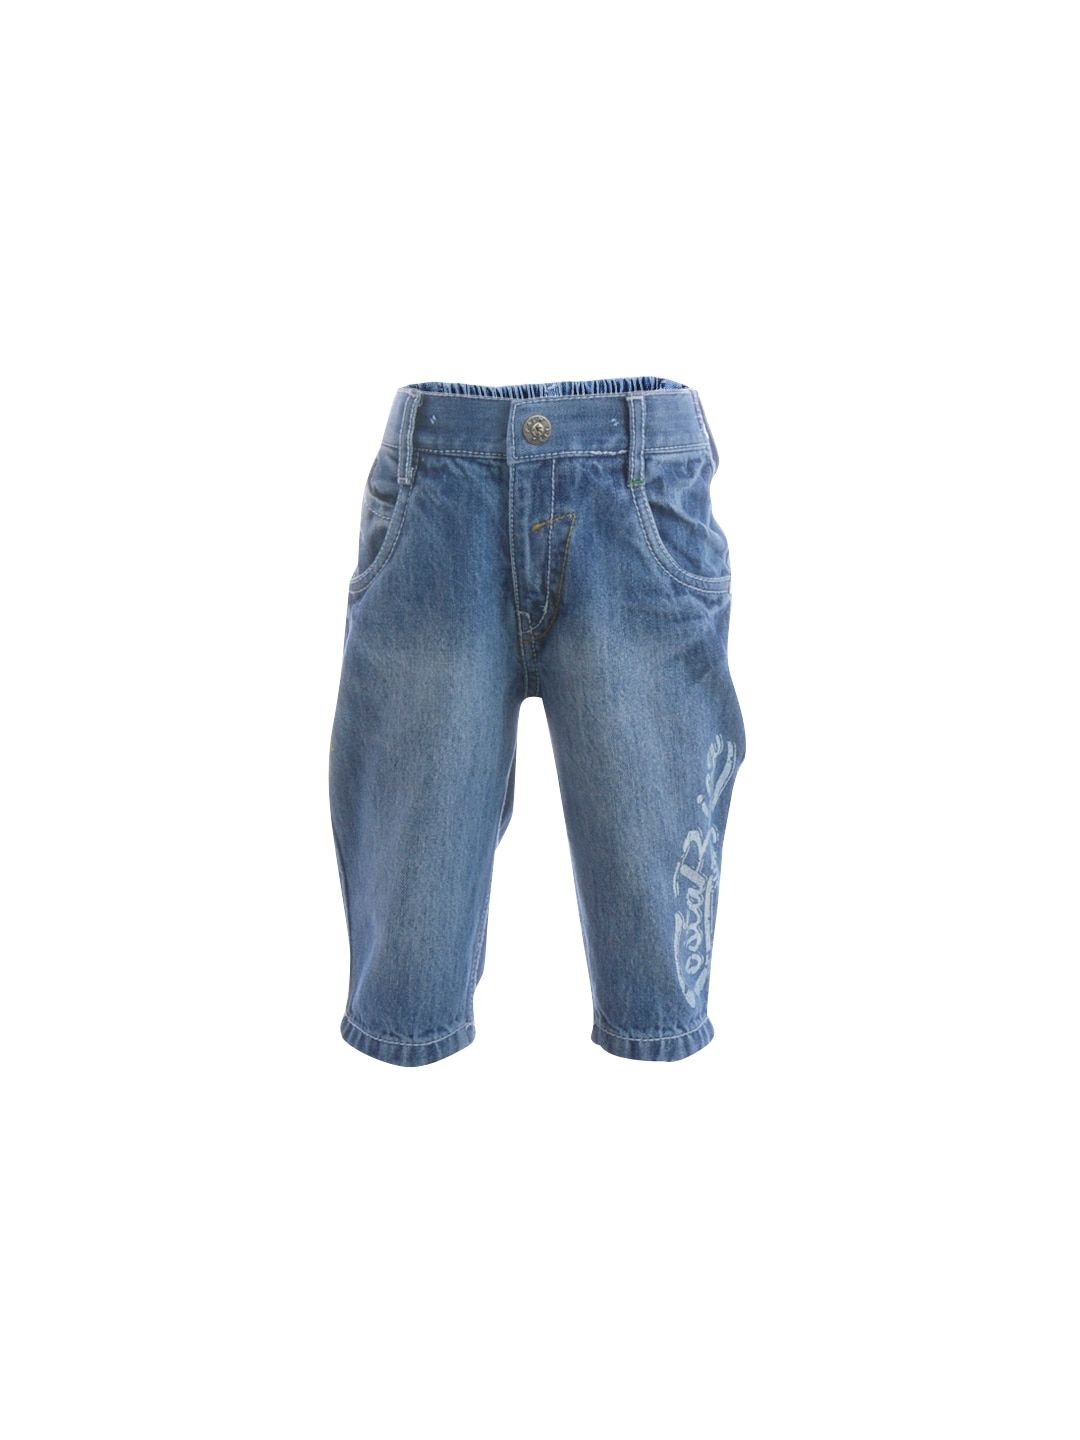

Product Title:  Palm Tree Boys Washed Blue 3/4 Length Pants
Euclidean Distance from input image: 28.973797


In [18]:
get_similar_products_cnn('18181', 5)

==================== input product details ====================


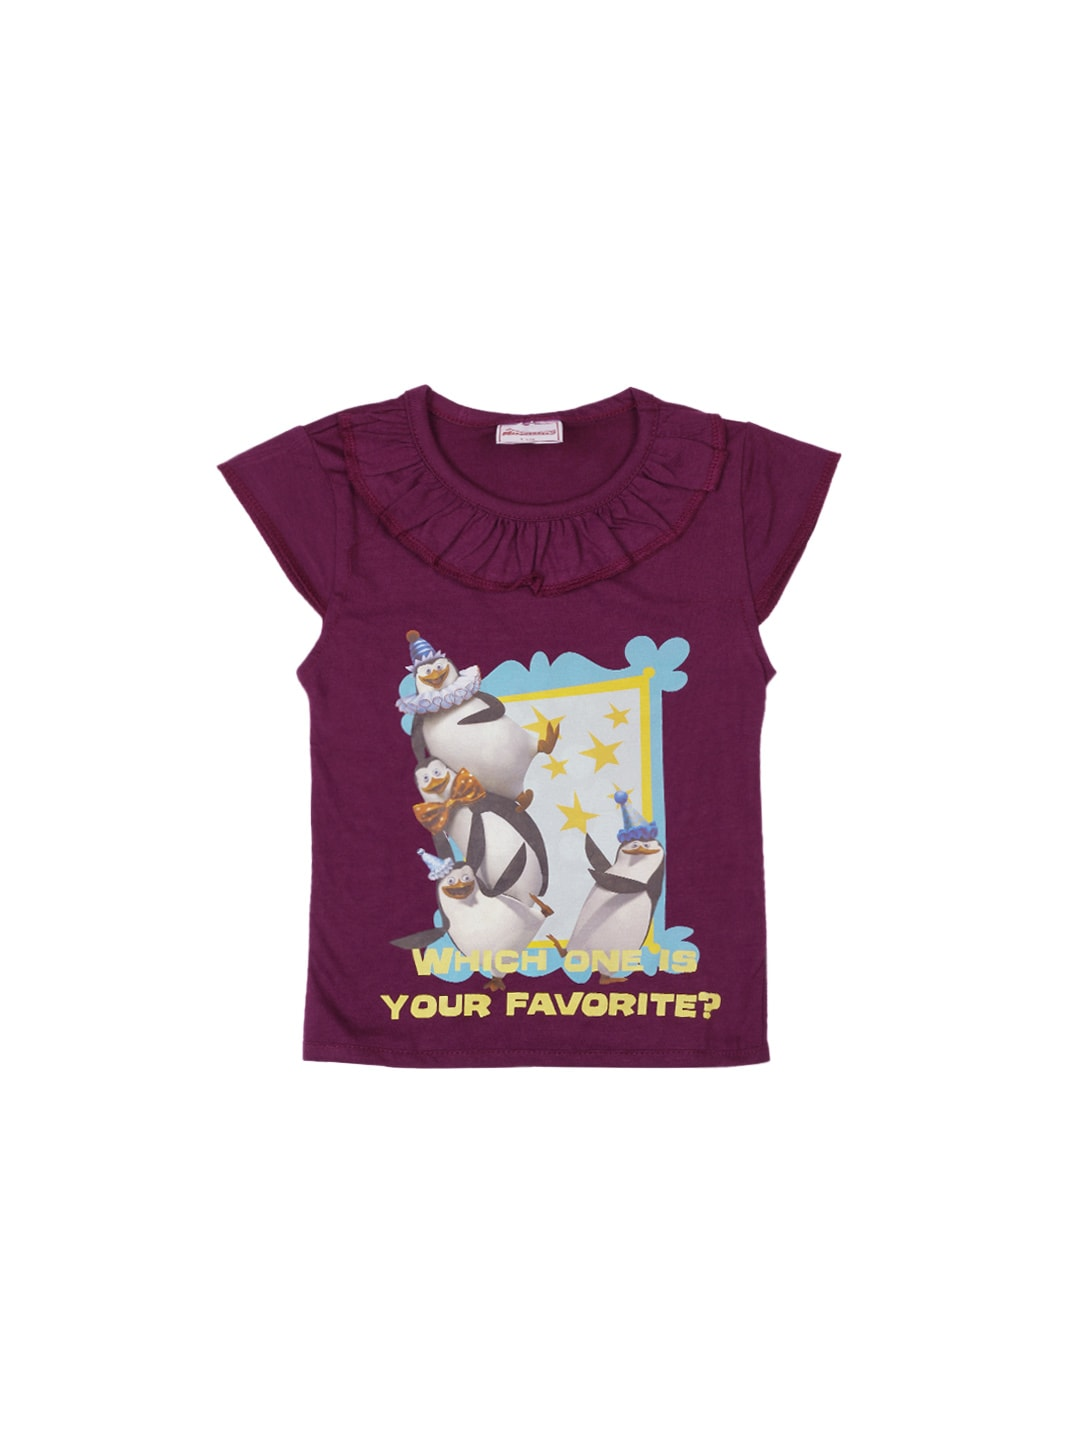

Product Title:  Madagascar3 Girls Purple Printed T-Shirt

 ==================== Recommended products ====================


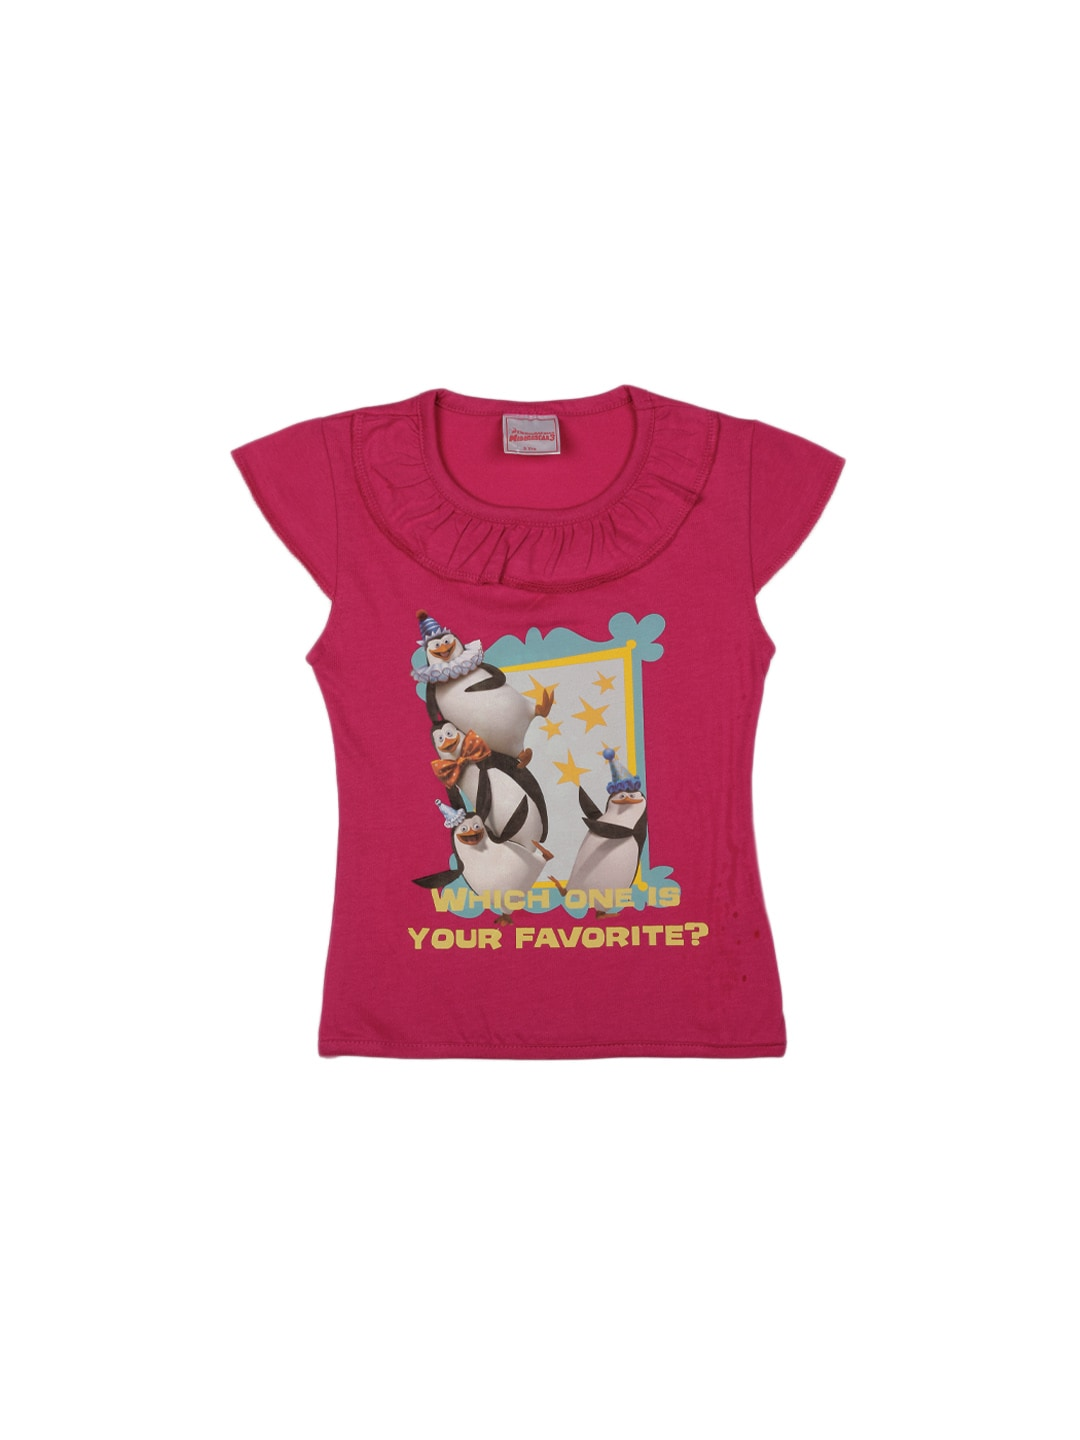

Product Title:  Madagascar3 Girls Pink Printed T-Shirt
Euclidean Distance from input image: 24.715086


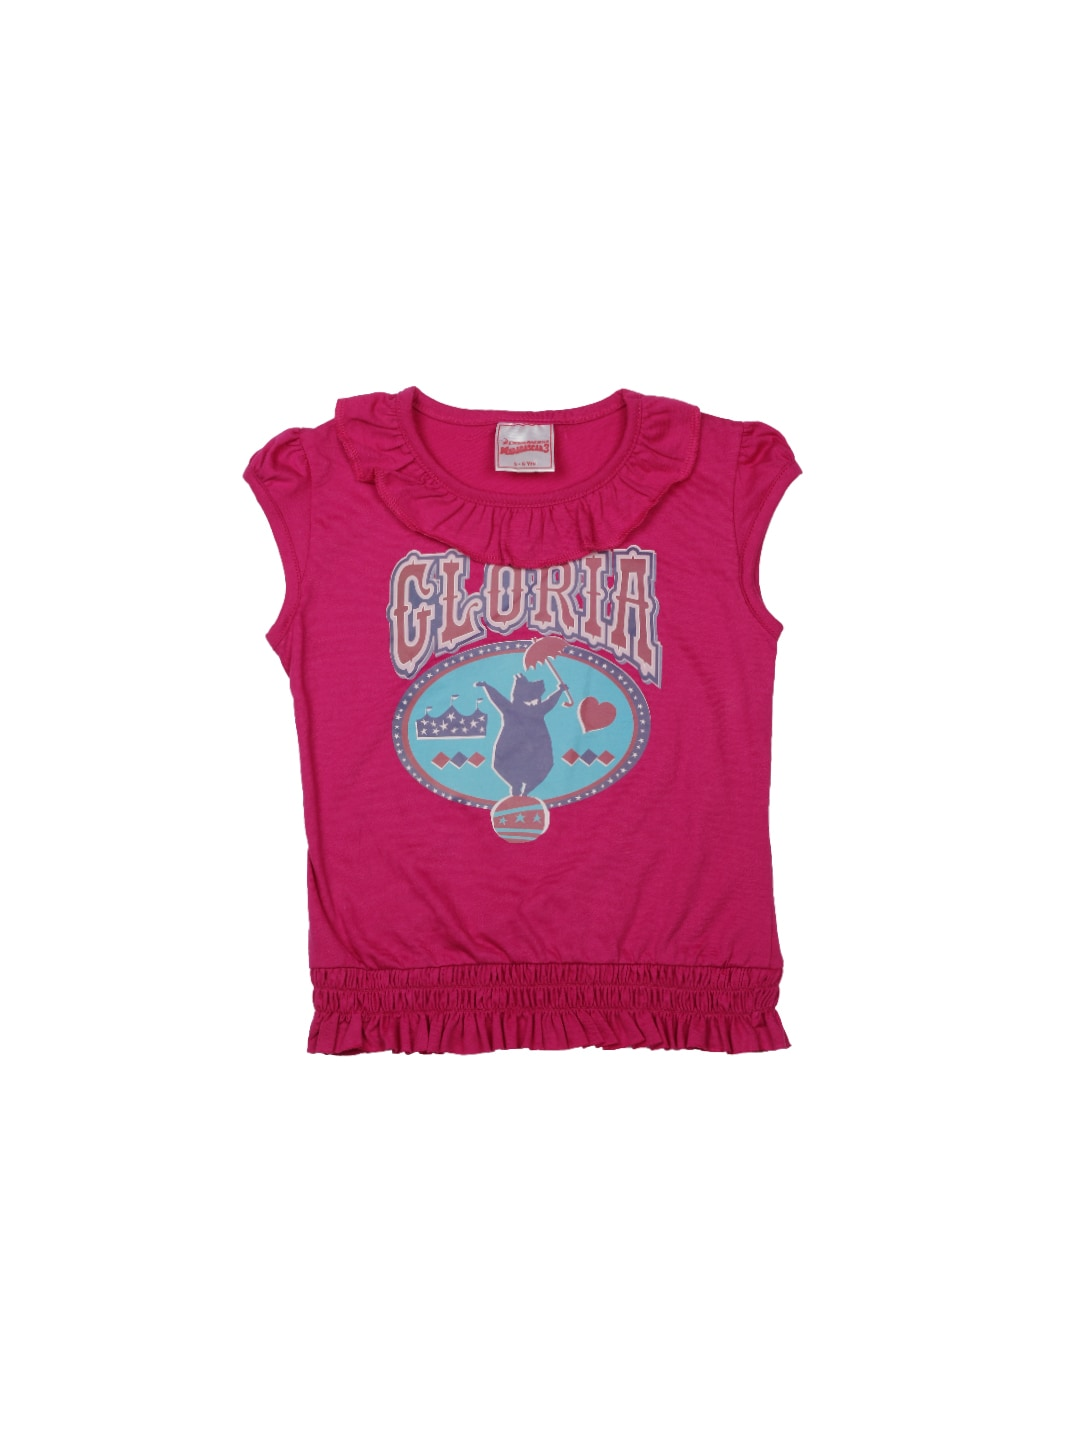

Product Title:  Madagascar3 Girls Pink Printed T-Shirt
Euclidean Distance from input image: 32.679398


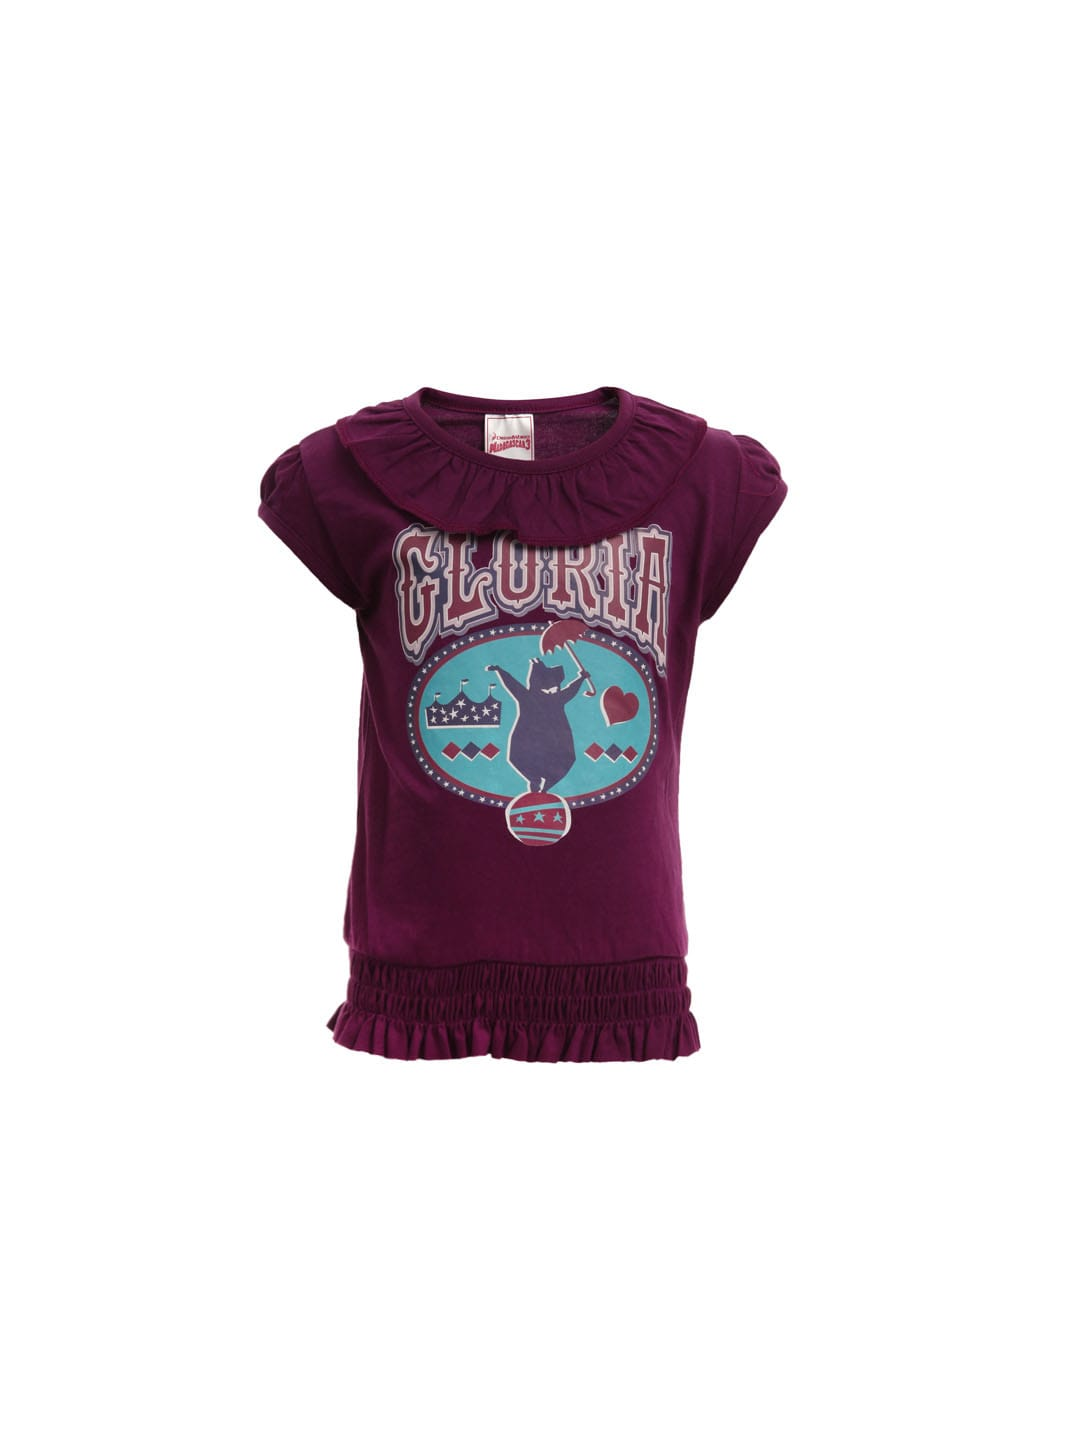

Product Title:  Madagascar3 Girls Purple Printed T-Shirt
Euclidean Distance from input image: 35.671


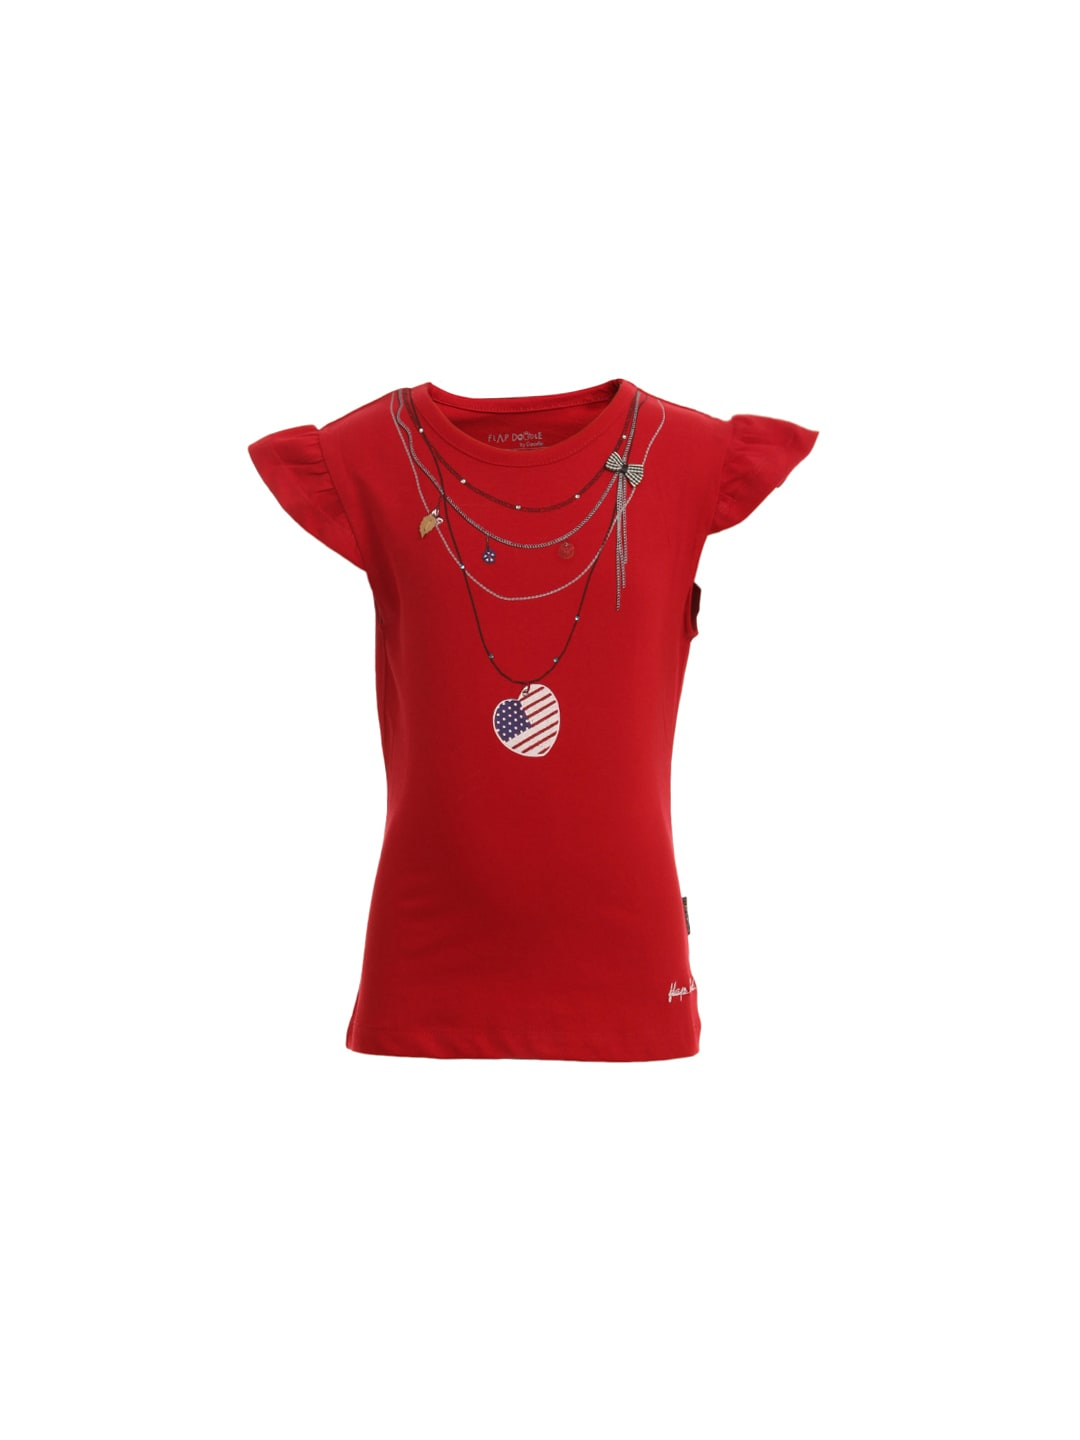

Product Title:  Doodle Girls Red Printed Top
Euclidean Distance from input image: 35.865276


In [19]:
get_similar_products_cnn('37633', 5)

**Tip** - The solution can be deployed using ***streamlit***.

The complete deployment code can be downloaded from [here](https://drive.google.com/file/d/123XGxKvRY7sk2pnTmVOyLp9FH-iFL5oN/view).